<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Explore-other-reward-functions" data-toc-modified-id="Explore-other-reward-functions-1">Explore other reward functions</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-1.3">Code</a></span><ul class="toc-item"><li><span><a href="#Data-generation" data-toc-modified-id="Data-generation-1.3.1">Data generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.3.2">Evaluation</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.3.3">Visualization</a></span></li></ul></li><li><span><a href="#Starting-the-ladder" data-toc-modified-id="Starting-the-ladder-1.4">Starting the ladder</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.4.2">Evaluation</a></span></li><li><span><a href="#Measuring-epsilon-agent-strength" data-toc-modified-id="Measuring-epsilon-agent-strength-1.4.3">Measuring epsilon agent strength</a></span><ul class="toc-item"><li><span><a href="#Experiments" data-toc-modified-id="Experiments-1.4.3.1">Experiments</a></span></li></ul></li></ul></li><li><span><a href="#Playing-against-greedy-agents" data-toc-modified-id="Playing-against-greedy-agents-1.5">Playing against greedy agents</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.5.1">Generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.5.2">Evaluation</a></span></li><li><span><a href="#Generate-again" data-toc-modified-id="Generate-again-1.5.3">Generate again</a></span></li><li><span><a href="#Evaluate-again" data-toc-modified-id="Evaluate-again-1.5.4">Evaluate again</a></span></li></ul></li><li><span><a href="#Study-importance-of-number-of-matches" data-toc-modified-id="Study-importance-of-number-of-matches-1.6">Study importance of number of matches</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.6.1">Generation</a></span><ul class="toc-item"><li><span><a href="#Debug" data-toc-modified-id="Debug-1.6.1.1">Debug</a></span></li><li><span><a href="#Production" data-toc-modified-id="Production-1.6.1.2">Production</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.6.2">Evaluation</a></span></li></ul></li><li><span><a href="#Study-reward-importance" data-toc-modified-id="Study-reward-importance-1.7">Study reward importance</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.7.1">Generation</a></span></li><li><span><a href="#Study-reward-distribution" data-toc-modified-id="Study-reward-distribution-1.7.2">Study reward distribution</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-1.7.2.1">Plots</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.7.2.2">Summary</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.7.3">Evaluation</a></span></li></ul></li><li><span><a href="#Architecture-study" data-toc-modified-id="Architecture-study-1.8">Architecture study</a></span></li><li><span><a href="#Useful-snippets" data-toc-modified-id="Useful-snippets-1.9">Useful snippets</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.10">Summary</a></span></li></ul></li></ul></div>

# Explore other reward functions

## Goal

The goal of this notebooks is to continue learning about the Q value function, but trying other reward methods.

This is a continuation of notebook 004, which had become too big. In this notebook I will split the functionality
of playing games and generating data from training from those games.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
import time
from itertools import permutations
from functools import partial
import gc
from concurrent.futures import ProcessPoolExecutor
import json
import logging
import glob
from IPython.display import clear_output

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras as keras

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position, combine_data, horizontal_simmetry, vertical_simmetry
from hungry_geese.utils import ACTIONS, opposite_action, get_timestamp, log_ram_usage, configure_logging
from hungry_geese.definitions import ACTION_TO_IDX
from hungry_geese.agents import EpsilonAgent, QValueAgent
from hungry_geese.evaluation import play_matches_in_parallel, monitor_progress
from hungry_geese.elo import EloRanking
from hungry_geese.model import simple_model, create_model_for_training

%config Completer.use_jedi = False

Loading environment football failed: No module named 'gfootball'


In [3]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

configure_logging(logging.INFO)
logger = logging.getLogger(__name__)

## Code

### Data generation

In [4]:
def play_matches_in_parallel_and_save_history(agents, max_workers=20, n_matches=1000,
                                              output_path=None,
                                              running_on_notebook=True):
    """
    Plays n_matches in parallel using ProcessPoolExecutor

    Parameters
    -----------
    agents : list
        List of the agents that we will use for playing
    """
    log_ram_usage()
    output_path = output_path or get_games_output_path(agents, n_matches)
    assert not os.path.exists(output_path), 'Output path already exists: %s' % output_path
    with ProcessPoolExecutor(max_workers=max_workers) as pool:
        matches_results = []
        submits = []
        for i in range(n_matches):
            if isinstance(agents, list):
                submits.append(pool.submit(play_game, agents=agents))
            elif callable(agents):
                submits.append(pool.submit(play_game, agents=agents()))
            else:
                raise TypeError(type(agents))
        monitor_progress(submits, running_on_notebook)
        matches_results = [submit.result() for submit in submits]
    
    log_ram_usage()
    logger.info('saving matches to json: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump(matches_results, f)
        
    del submits
    del matches_results
    gc.collect()
    log_ram_usage()

def play_game(agents):
    env = make("hungry_geese")
    return env.run(agents=agents)

def get_games_output_path(agents, n_matches):
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_path

In [5]:
def test_agent(agent):
    print('Testing agent: %s' % agent)
    env = make('hungry_geese', debug=True)
    env.run([agent]*4)

In [6]:
def create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    saved_games_paths : list of str
        Path to the games that we want to use
    reward_name : str
        Name of the reward function that we want to use
    output_path : str
        Path to the file were we are going to save the results
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    env = make("hungry_geese")
    conf = env.configuration

    state = GameState(reward_name=reward_name)
    train_data = []
    agent_idx_range = agent_idx_range or list(range(4))
    
    for saved_games_path in tqdm(saved_games_paths, desc='looping over saved games'):
        log_ram_usage()
        with open(saved_games_path, 'r') as f:
            matches_results = json.load(f)
        log_ram_usage()
    
        for _ in tqdm(range(len(matches_results)), desc='Creating game data'):
            match = matches_results[0]
            for idx in agent_idx_range:
                state.reset()
                for step_idx, step in enumerate(match):
                    observation = step[0]['observation'].copy()
                    observation['index'] = idx
                    state.update(observation, conf)
                    if step_idx:
                        state.add_action(step[idx]['action'])
                    if not observation['geese'][idx]:
                        break
                train_data.append(state.prepare_data_for_training())
            del matches_results[0]
        
    log_ram_usage()
    logger.info('Going to combine the data')
    train_data = combine_data(train_data)
    log_ram_usage()
    logger.info('Size of the boards is %.1f GB (%s [%.1f GB])' % (
        train_data[0].nbytes/1e9,
        str([round(data.nbytes/1e9, 1) for data in train_data]),
        np.sum([data.nbytes/1e9 for data in train_data])))
    logger.info('Saving data on: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, boards=train_data[0], features=train_data[1], actions=train_data[2], rewards=train_data[3])
    del state
    del train_data
    gc.collect()
    log_ram_usage()

In [7]:
def create_train_data(agents, n_matches, reward_name, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    agents : list of str
        Names or paths of the agents
    n_matches : int
        Number of matches to play
    reward_name : str
        Name of the reward function that we want to use
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    saved_games_path = get_games_output_path(agents, n_matches)
    if not os.path.exists(saved_games_path):
        play_matches_in_parallel_and_save_history(agents, n_matches=n_matches)

    output_path = get_data_output_path(agents, n_matches, reward_name)
    create_train_data_from_saved_matches([saved_games_path], reward_name, output_path, agent_idx_range=agent_idx_range)
    
def get_data_output_path(agents, n_matches, reward_name):
    output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
        reward_name,
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_file

### Evaluation

In [8]:
initial_elo_ranking = pd.read_csv('../data/elo_ranking.csv', index_col='model')
initial_elo_ranking

,ranking
model,
quantum,1398
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


In [9]:
agents = {
    'random': 'random',
    'random_plus': '../forum/agents/random_plus.py',
    'greedy': 'greedy',
    'risk_averse_goose': '../forum/agents/risk_averse_goose.py',
    'goose_on_a_healthy_diet': '../forum/agents/goose_on_a_healthy_diet.py',
    'straightforward_bfs': '../forum/agents/straightforward_bfs.py',
    'boilergoose': '../forum/agents/boilergoose.py',
    'crazy_goose': '../forum/agents/crazy_goose.py',
    'besthoarder': '../forum/agents/besthoarder.py',
    'greedyhoarder': '../forum/agents/greedyhoarder.py',
    'quantum': '../data/agents/quantum/quantum.py',
}

In [10]:
def evaluate_agent(new_agent, adversary_agents, n_matches, single_agent=True, max_workers=20, run_agent_test=False):
    agent_name = list(new_agent.keys())[0]
    # I have found that for certain agents if the test is run then evaluation is frozen
    if run_agent_test: test_agent(new_agent[agent_name])
    reduced_agents_set = new_agent.copy()
    for adversary_agent in adversary_agents:
        reduced_agents_set[adversary_agent] = agents[adversary_agent]
    
    if single_agent:
        sample_agents_func = lambda: [agent_name] + np.random.choice(adversary_agents, 3, replace=False).tolist()
    else:
        def sample_agents_func():
            while 1:
                sampled_agents = [agent_name] + np.random.choice(adversary_agents + [agent_name], 3).tolist()
                if len(np.unique(sampled_agents)) >=2:
                    break
            return sampled_agents

    matches_agents, matches_results = play_matches_in_parallel(reduced_agents_set, sample_agents_func, n_matches=n_matches, max_workers=max_workers)
    return matches_agents, matches_results, reduced_agents_set
    
def compute_elo_ranking(matches_agents, matches_results, reduced_agents_set):
    initial_agent_elo = 1000
    for k in [32, 16, 8, 4, 2, 1]:
        agent_name = [name for name in reduced_agents_set if name not in initial_elo_ranking][0]
        initial_ranking = initial_elo_ranking.to_dict()['ranking']
        initial_ranking[agent_name] = initial_agent_elo
        initial_ranking = {key: initial_ranking[key] for key in reduced_agents_set}
        elo_ranking = EloRanking(initial_ranking, {agent_name}, k=k)
        for match_agents, match_results in zip(matches_agents, matches_results):
            elo_ranking.add_match(match_agents, match_results)
        initial_agent_elo = elo_ranking.summary().loc[agent_name, 'ranking']
    elo_ranking.plot()
    return elo_ranking.summary()

In [11]:
def simple_agent_evaluation(agent_path, n_matches=500):
    """
    Computes single and multi agents scores and returns them
    
    Parameters
    ----------
    multi_agent_elo_score
    single_agent_elo_score
    """
    ret = evaluate_agent(
        {'q_value_pretrained': agent_path},
        initial_elo_ranking.index.values.tolist()[:5],
        n_matches=n_matches, single_agent=False, max_workers=20)
    table_multi = compute_elo_ranking(*ret)
    ret = evaluate_agent(
        {'q_value_pretrained': agent_path},
        initial_elo_ranking.index.values.tolist()[:5],
        n_matches=n_matches, single_agent=True, max_workers=20)
    table_single = compute_elo_ranking(*ret)
    plt.close('all')
    clear_output()
    print(agent_path)
    print('Multi agent elo score: %i' % table_multi.loc['q_value_pretrained', 'ranking'])
    print('Single agent elo score: %i' % table_single.loc['q_value_pretrained', 'ranking'])
    return table_multi.loc['q_value_pretrained', 'ranking'], table_single.loc['q_value_pretrained', 'ranking']

### Visualization

In [12]:
def plot_q_value(agent):
    values = np.array(agent.q_values)
    for idx, action in enumerate(ACTIONS):
        plt.plot(values[:, idx], label=action, alpha=0.6)
    plt.legend(loc=0)
    plt.grid(axis='x')

In [13]:
def save_html_games(agents, output_folder, n_games=10):
    os.makedirs(output_folder, exist_ok=True)
    env = make('hungry_geese')
    for game_idx in tqdm(range(n_games)):
        ret = env.run(agents);
        html_content = env.render(mode="html")
        filepath = os.path.join(output_folder, '%02d.html' % game_idx)
        with open(filepath, 'w') as f:
            f.write(html_content)

## Starting the ladder

### Generation

In [12]:
n_matches = 2000
agents = ['../data/agents/quantum/epsilon_quantum_025.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-21 17:50:51,464 - hungry_geese.utils - INFO - ram_memory used: 0.36 GB	 available: 61.25 GB


  0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-21 17:54:22,213 - hungry_geese.utils - INFO - ram_memory used: 1.94 GB	 available: 59.63 GB
2021-03-21 17:54:22,214 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_025_vs_epsilon_quantum_025_matches_2000.json
2021-03-21 17:54:37,962 - hungry_geese.utils - INFO - ram_memory used: 0.36 GB	 available: 61.00 GB
2021-03-21 17:54:43,063 - hungry_geese.utils - INFO - ram_memory used: 1.46 GB	 available: 59.82 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-21 17:55:25,648 - hungry_geese.utils - INFO - ram_memory used: 4.24 GB	 available: 57.17 GB
2021-03-21 17:55:26,392 - __main__ - INFO - Size of the boards is 3.4 GB
2021-03-21 17:55:26,393 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_025_vs_epsilon_quantum_025_matches_2000.npz
2021-03-21 17:55:44,807 - hungry_geese.utils - INFO - ram_memory used: 3.75 GB	 available: 57.58 GB


In [12]:
n_matches = 30000
agents = ['../data/agents/quantum/epsilon_quantum_025.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-21 17:57:44,041 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.32 GB


  0%|          | 0/30000 [00:00<?, ?it/s]

2021-03-21 18:50:12,825 - hungry_geese.utils - INFO - ram_memory used: 24.25 GB	 available: 38.02 GB
2021-03-21 18:50:12,825 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_025_vs_epsilon_quantum_025_matches_30000.json
2021-03-21 18:54:02,817 - hungry_geese.utils - INFO - ram_memory used: 0.41 GB	 available: 60.76 GB
2021-03-21 18:55:14,654 - hungry_geese.utils - INFO - ram_memory used: 16.99 GB	 available: 44.28 GB


Creating game data:   0%|          | 0/30000 [00:00<?, ?it/s]

2021-03-21 19:05:37,662 - hungry_geese.utils - INFO - ram_memory used: 58.82 GB	 available: 2.52 GB
2021-03-21 19:08:11,546 - __main__ - INFO - Size of the boards is 50.6 GB
2021-03-21 19:08:11,609 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_025_vs_epsilon_quantum_025_matches_30000.npz
2021-03-21 19:14:18,763 - hungry_geese.utils - INFO - ram_memory used: 13.30 GB	 available: 51.30 GB


### Evaluation

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1366
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


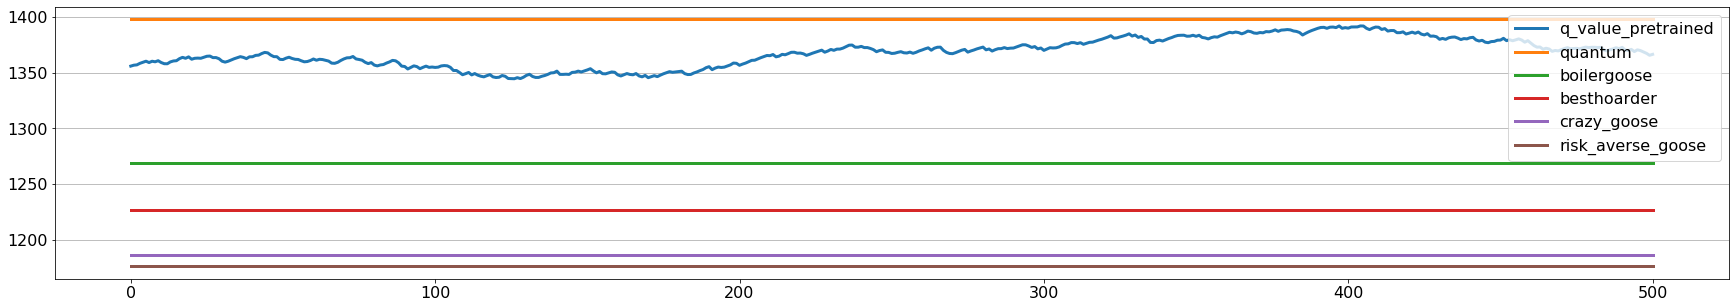

In [12]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/01_epsilon025_reward_-4_4_x128_30000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1360
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


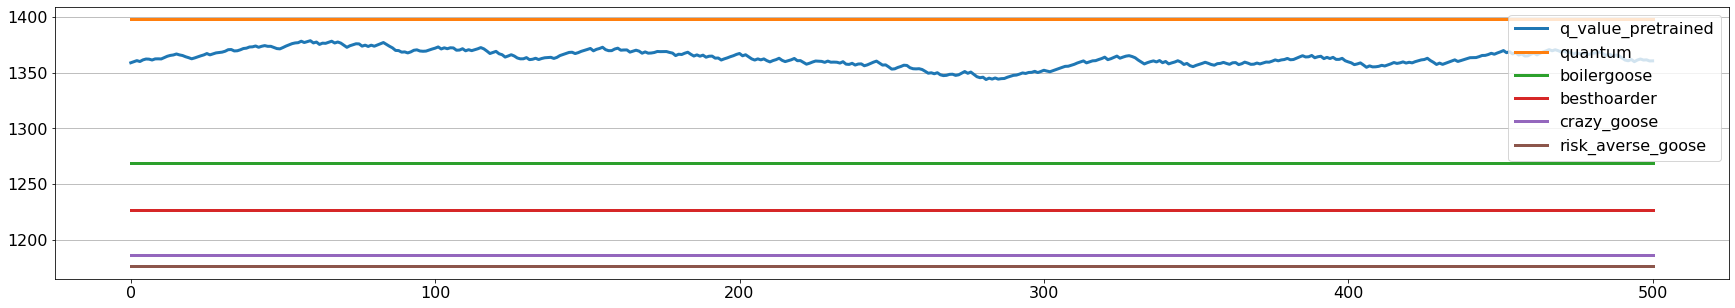

In [13]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/01_epsilon025_reward_-4_4_x128_30000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1357
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


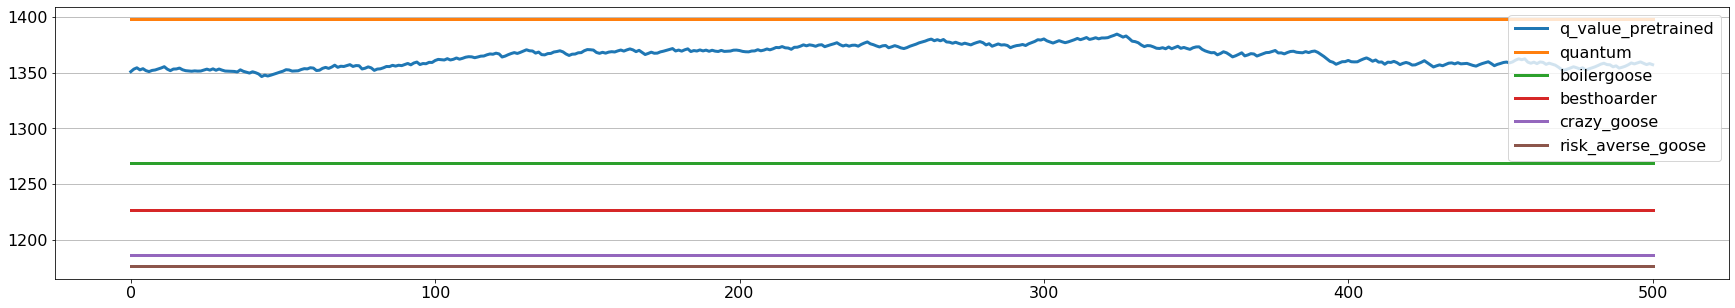

In [14]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/02_epsilon025_reward_-4_4_x128_30000_from_zero/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

I have the hypothesis that maybe the new agent is weak because it plays only against epsilon agents. Let's see how weak an epsilon agent is:

### Measuring epsilon agent strength

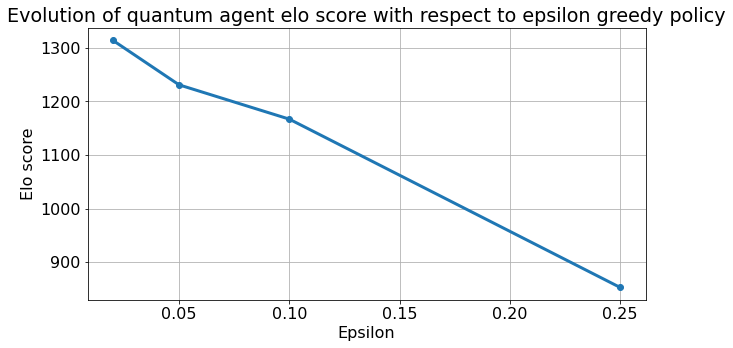

In [22]:
plt.figure(figsize=(10, 5))
epsilon = [0.25, 0.1, 0.05, 0.02]
elo = [853, 1167, 1231, 1314]
plt.plot(epsilon, elo, marker='o')
plt.grid()
plt.xlabel('Epsilon')
plt.ylabel('Elo score')
plt.title('Evolution of quantum agent elo score with respect to epsilon greedy policy');

#### Experiments

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
epsilon_quantum_025,853
greedyhoarder,766


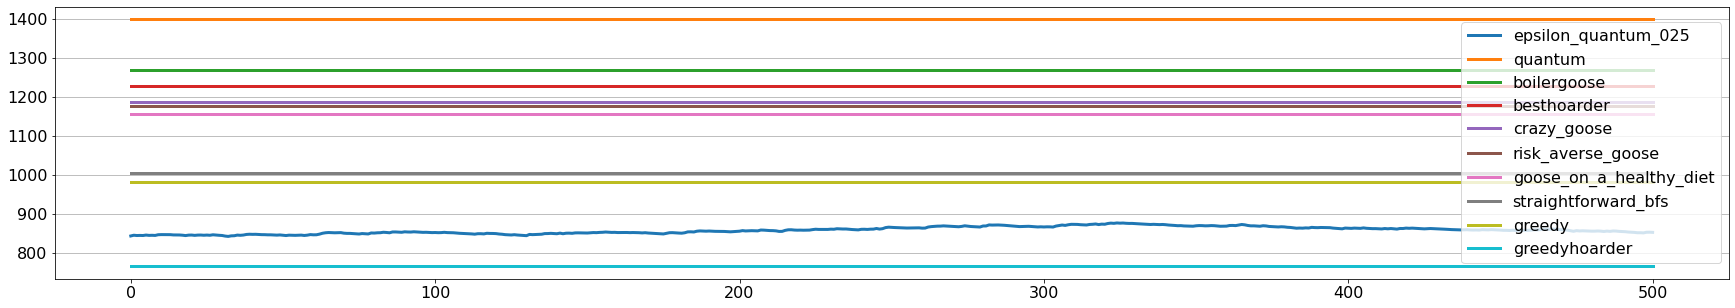

In [13]:
ret = evaluate_agent(
    {'epsilon_quantum_025': '../data/agents/quantum/epsilon_quantum_025.py'},
    initial_elo_ranking.index.values.tolist()[:-2],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

This is very relevant. Let's try with different values of epsilon.

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
epsilon_quantum_010,1167
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


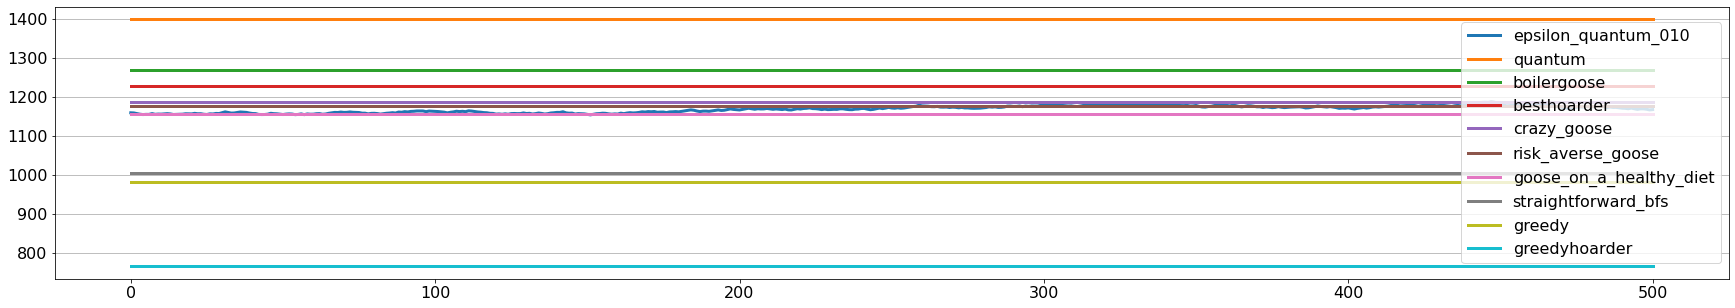

In [15]:
ret = evaluate_agent(
    {'epsilon_quantum_010': '../data/agents/quantum/epsilon_quantum_010.py'},
    initial_elo_ranking.index.values.tolist()[:-2],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
boilergoose,1269
epsilon_quantum_005,1231
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


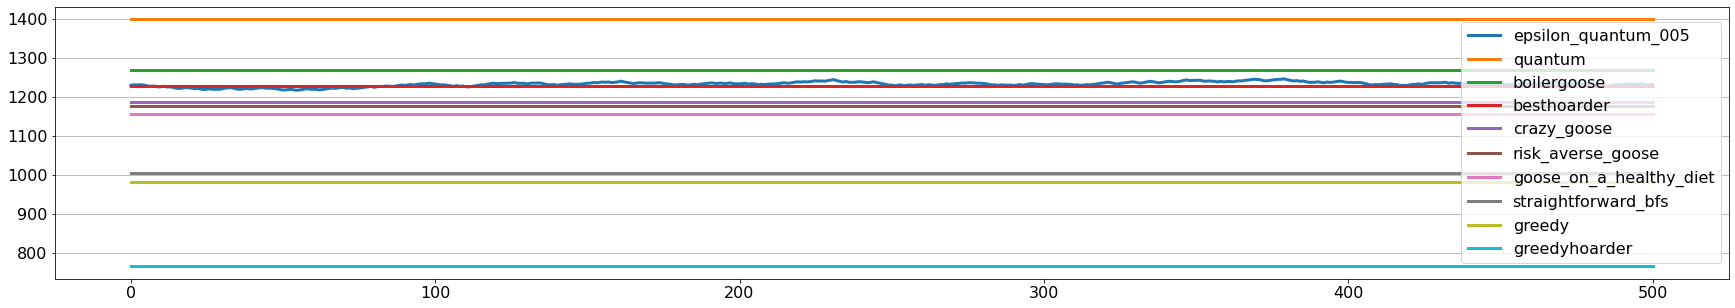

In [16]:
ret = evaluate_agent(
    {'epsilon_quantum_005': '../data/agents/quantum/epsilon_quantum_005.py'},
    initial_elo_ranking.index.values.tolist()[:-2],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
epsilon_quantum_002,1314
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766


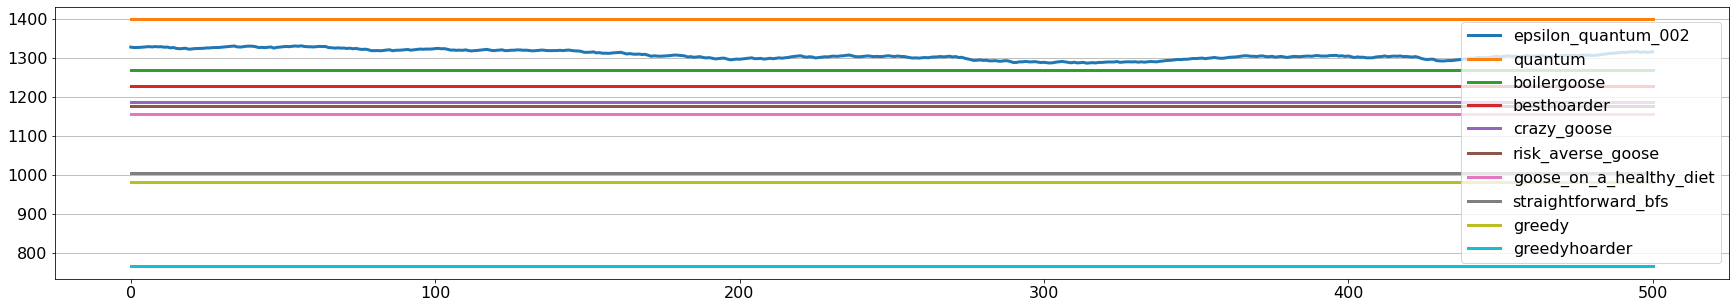

In [17]:
ret = evaluate_agent(
    {'epsilon_quantum_002': '../data/agents/quantum/epsilon_quantum_002.py'},
    initial_elo_ranking.index.values.tolist()[:-2],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

## Playing against greedy agents

### Generation 

On a first step I have to modify the current generation functions to support giving a sampling function for the agents and also to enable using more than one json file for creating data.

In [12]:
agent_base = '../data/agents/quantum/epsilon_quantum_025.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:5]]
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()
n_matches = 100

output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)

2021-03-22 13:10:13,066 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.63 GB


  0%|          | 0/100 [00:00<?, ?it/s]

2021-03-22 13:10:23,575 - hungry_geese.utils - INFO - ram_memory used: 0.46 GB	 available: 61.50 GB
2021-03-22 13:10:23,576 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_025_vs_best5_matches_100.json
2021-03-22 13:10:24,921 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 61.61 GB


In [13]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:5]]
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()

for n_matches in [8000, 40000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)

2021-03-22 13:11:21,186 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 61.64 GB


  0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-22 13:25:21,052 - hungry_geese.utils - INFO - ram_memory used: 10.44 GB	 available: 51.49 GB
2021-03-22 13:25:21,052 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_010_vs_best5_matches_8000.json
2021-03-22 13:27:00,110 - hungry_geese.utils - INFO - ram_memory used: 0.38 GB	 available: 61.58 GB
2021-03-22 13:27:00,112 - hungry_geese.utils - INFO - ram_memory used: 0.38 GB	 available: 61.58 GB


  0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-22 14:38:32,992 - hungry_geese.utils - INFO - ram_memory used: 45.88 GB	 available: 19.20 GB
2021-03-22 14:38:33,001 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_010_vs_best5_matches_40000.json
2021-03-22 14:47:53,246 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 64.49 GB


In [29]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
reward_name = 'ranking_reward_-4_4'

for n_matches in [8000, 40000]:
    saved_games_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    create_train_data_from_saved_matches([saved_games_path], reward_name, output_path, agent_idx_range=[0])

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-22 15:02:53,825 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 63.71 GB


Creating game data:   0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-22 15:04:44,313 - hungry_geese.utils - INFO - ram_memory used: 7.12 GB	 available: 56.82 GB
2021-03-22 15:04:45,623 - __main__ - INFO - Size of the boards is 5.4 GB
2021-03-22 15:04:45,624 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_matches_8000.npz
2021-03-22 15:05:15,772 - hungry_geese.utils - INFO - ram_memory used: 5.73 GB	 available: 58.26 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-22 15:05:15,792 - hungry_geese.utils - INFO - ram_memory used: 5.73 GB	 available: 58.26 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-22 15:14:00,175 - hungry_geese.utils - INFO - ram_memory used: 34.43 GB	 available: 29.48 GB
2021-03-22 15:14:13,729 - __main__ - INFO - Size of the boards is 26.7 GB
2021-03-22 15:14:13,731 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_matches_40000.npz
2021-03-22 15:16:41,399 - hungry_geese.utils - INFO - ram_memory used: 27.32 GB	 available: 36.73 GB


In [28]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:5]]
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()

for n_matches in [39000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)
    
reward_name = 'ranking_reward_-4_4'

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [39000, 40000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 80000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

2021-03-22 16:17:27,725 - hungry_geese.utils - INFO - ram_memory used: 0.37 GB	 available: 62.89 GB


  0%|          | 0/39000 [00:00<?, ?it/s]

2021-03-22 17:27:15,904 - hungry_geese.utils - INFO - ram_memory used: 45.47 GB	 available: 19.00 GB
2021-03-22 17:27:15,913 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_010_vs_best5_matches_39000.json
2021-03-22 17:36:37,252 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 64.03 GB


looping over saved games:   0%|          | 0/2 [00:00<?, ?it/s]

2021-03-22 17:36:37,359 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 64.03 GB


Creating game data:   0%|          | 0/39000 [00:00<?, ?it/s]

2021-03-22 17:44:50,477 - hungry_geese.utils - INFO - ram_memory used: 33.53 GB	 available: 30.59 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-22 17:54:20,917 - hungry_geese.utils - INFO - ram_memory used: 63.97 GB	 available: 0.77 GB
2021-03-22 18:01:01,262 - __main__ - INFO - Size of the boards is 52.9 GB
2021-03-22 18:01:01,344 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_matches_80000.npz
2021-03-22 18:11:10,434 - hungry_geese.utils - INFO - ram_memory used: 11.64 GB	 available: 52.57 GB


### Evaluation

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
boilergoose,1269
q_value_pretrained,1238
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


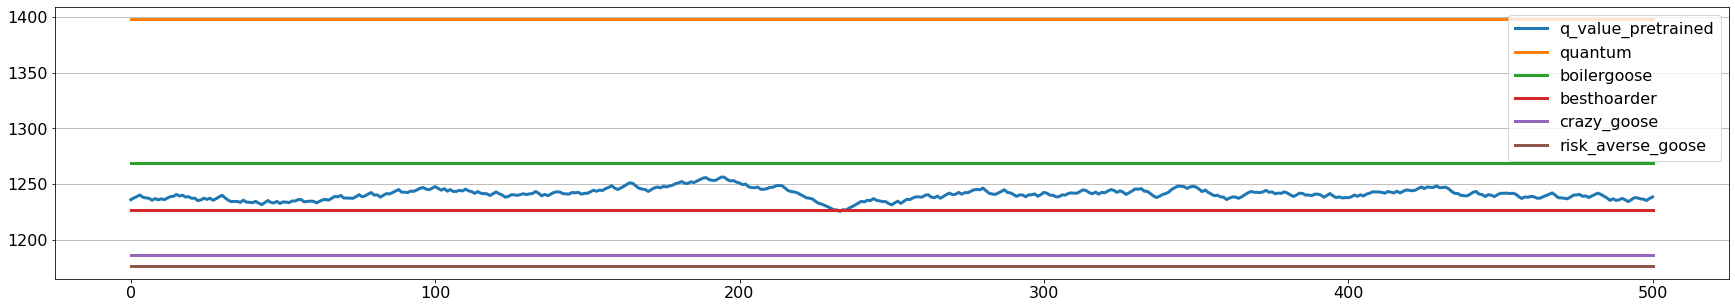

In [14]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/03_epsilon010_vs_best5_reward_-4_4_x128_40000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1382
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


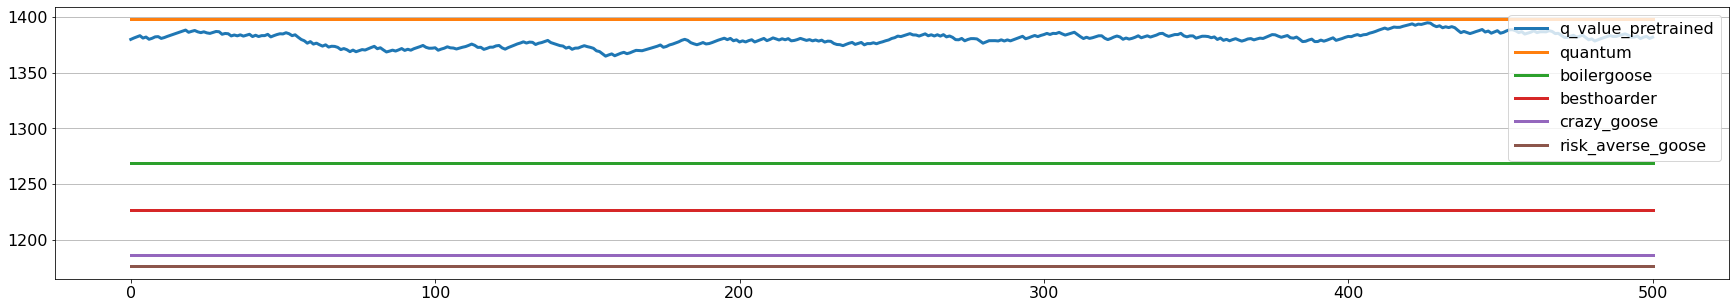

In [15]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/03_epsilon010_vs_best5_reward_-4_4_x128_40000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1290
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


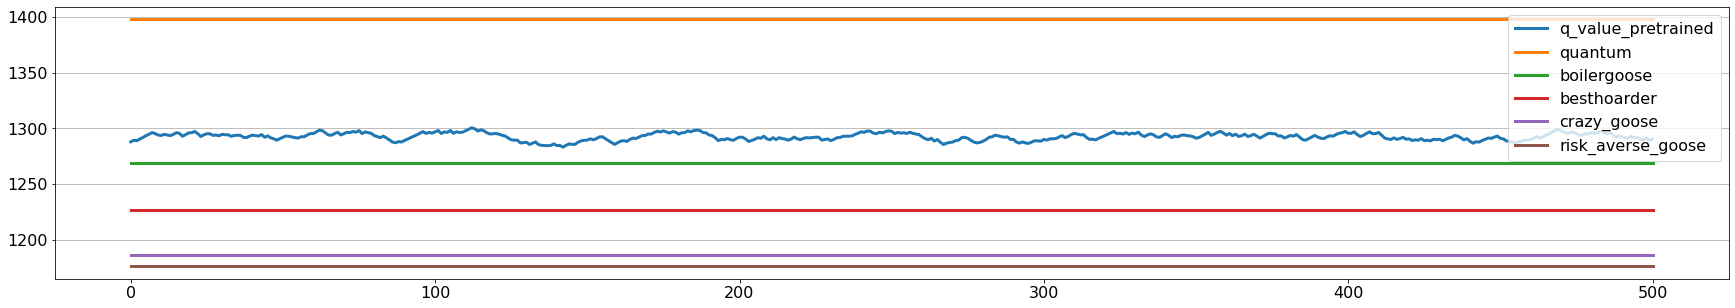

In [15]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/04_epsilon010_vs_best5_reward_-4_4_x128_80000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
q_value_pretrained,1431
quantum,1398
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


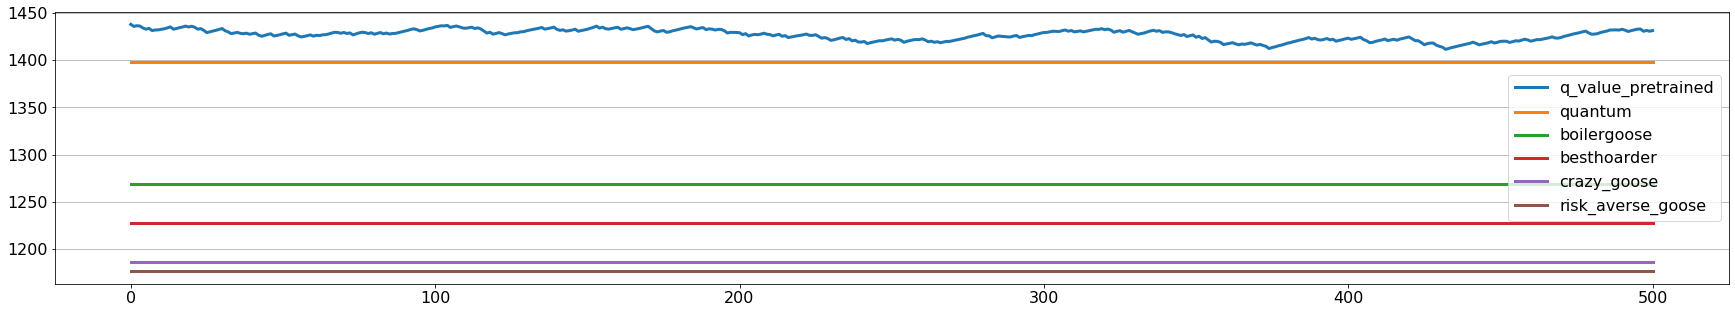

In [16]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/04_epsilon010_vs_best5_reward_-4_4_x128_80000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

### Generate again 

In [ ]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:4]]
best_5_agents += ['/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/04_epsilon010_vs_best5_reward_-4_4_x128_80000_pretrained/q_value_agent.py']
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()

for n_matches in [8000, 39000, 40000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)
    
reward_name = 'ranking_reward_-4_4'

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [8000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 8000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [39000, 40000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 80000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

2021-03-23 14:38:14,824 - hungry_geese.utils - INFO - ram_memory used: 0.36 GB	 available: 62.78 GB


  0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-23 14:53:58,450 - hungry_geese.utils - INFO - ram_memory used: 10.67 GB	 available: 52.47 GB
2021-03-23 14:53:58,451 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_010_vs_best5_it2_matches_8000.json
2021-03-23 14:55:38,915 - hungry_geese.utils - INFO - ram_memory used: 0.39 GB	 available: 62.78 GB
2021-03-23 14:55:38,917 - hungry_geese.utils - INFO - ram_memory used: 0.39 GB	 available: 62.78 GB


  0%|          | 0/39000 [00:00<?, ?it/s]

2021-03-23 16:14:17,370 - hungry_geese.utils - INFO - ram_memory used: 47.05 GB	 available: 17.99 GB
2021-03-23 16:14:17,373 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_010_vs_best5_it2_matches_39000.json
2021-03-23 16:23:10,327 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 64.59 GB
2021-03-23 16:23:10,329 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 64.59 GB


  0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-23 17:44:28,459 - hungry_geese.utils - INFO - ram_memory used: 47.08 GB	 available: 17.85 GB
2021-03-23 17:44:28,469 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_quantum_010_vs_best5_it2_matches_40000.json
2021-03-23 17:53:52,537 - hungry_geese.utils - INFO - ram_memory used: 0.29 GB	 available: 64.50 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-23 17:53:52,645 - hungry_geese.utils - INFO - ram_memory used: 0.30 GB	 available: 64.50 GB


Creating game data:   0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-23 17:55:47,480 - hungry_geese.utils - INFO - ram_memory used: 7.62 GB	 available: 57.11 GB
2021-03-23 17:55:49,295 - __main__ - INFO - Size of the boards is 5.9 GB
2021-03-23 17:55:49,296 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_it2_matches_8000.npz
2021-03-23 17:56:21,928 - hungry_geese.utils - INFO - ram_memory used: 6.24 GB	 available: 58.56 GB


looping over saved games:   0%|          | 0/2 [00:00<?, ?it/s]

2021-03-23 17:56:21,948 - hungry_geese.utils - INFO - ram_memory used: 6.24 GB	 available: 58.56 GB


Creating game data:   0%|          | 0/39000 [00:00<?, ?it/s]

2021-03-23 18:05:44,248 - hungry_geese.utils - INFO - ram_memory used: 36.45 GB	 available: 28.19 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-23 18:15:07,167 - hungry_geese.utils - INFO - ram_memory used: 64.67 GB	 available: 0.18 GB


In [13]:
# rerun due to kernel death
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:4]]
best_5_agents += ['/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/04_epsilon010_vs_best5_reward_-4_4_x128_80000_pretrained/q_value_agent.py']
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()
reward_name = 'ranking_reward_-4_4'


saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [40000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 40000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-23 19:44:54,373 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 64.30 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-23 19:54:30,060 - hungry_geese.utils - INFO - ram_memory used: 37.53 GB	 available: 27.01 GB
2021-03-23 19:54:47,541 - __main__ - INFO - Size of the boards is 29.8 GB
2021-03-23 19:54:47,608 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_it2_matches_40000.npz
2021-03-23 19:57:31,748 - hungry_geese.utils - INFO - ram_memory used: 30.32 GB	 available: 34.56 GB


In [ ]:
# rerun due to kernel death
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:4]]
best_5_agents += ['/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/04_epsilon010_vs_best5_reward_-4_4_x128_80000_pretrained/q_value_agent.py']
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()
reward_name = 'ranking_reward_-4_4'


saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [39000, 40000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 80000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

looping over saved games:   0%|          | 0/2 [00:00<?, ?it/s]

2021-03-23 18:44:46,772 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 64.33 GB


Creating game data:   0%|          | 0/39000 [00:00<?, ?it/s]

2021-03-23 18:54:12,142 - hungry_geese.utils - INFO - ram_memory used: 36.55 GB	 available: 28.02 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-23 19:05:15,953 - hungry_geese.utils - INFO - ram_memory used: 64.49 GB	 available: 0.19 GB


### Evaluate again

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1285
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


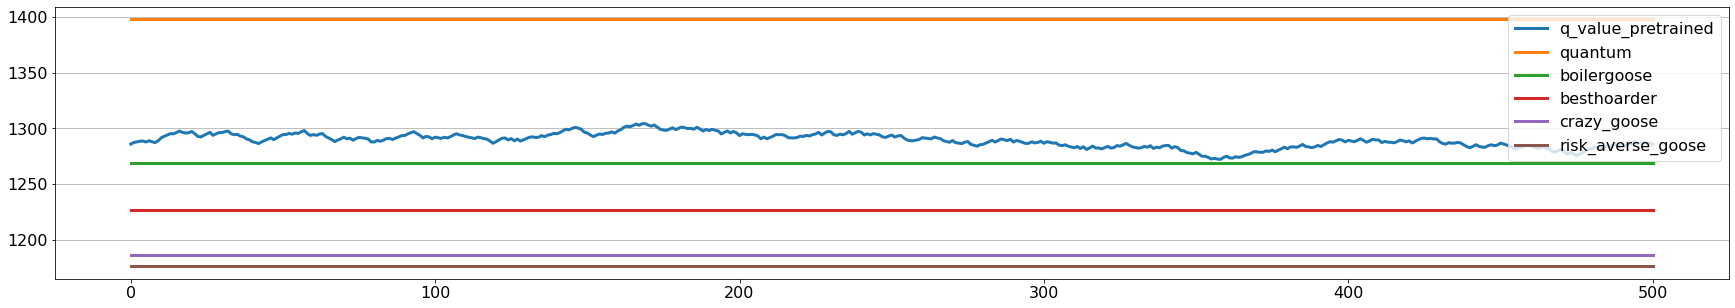

In [13]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/05_epsilon010_vs_best5_it2_reward_-4_4_x128_40000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
quantum,1398
q_value_pretrained,1354
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176


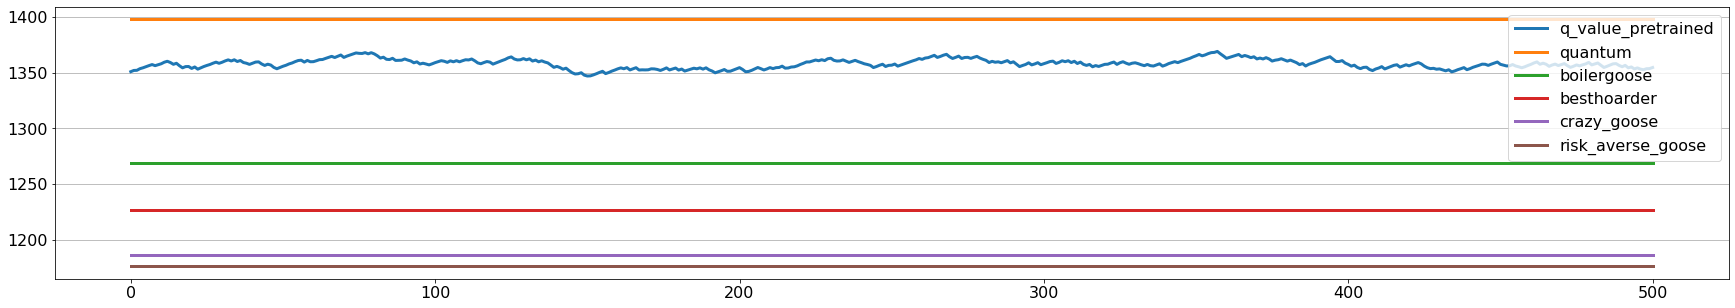

In [14]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/05_epsilon010_vs_best5_it2_reward_-4_4_x128_40000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

## Study importance of number of matches

I'm going to try to reduce dataset size and memory footprint of data generation to enable using a bigger number of games for training.

### Generation

#### Debug

Let's start with a small json file to get a baseline and improve over it.

##### Reduce dataset size

In [15]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 07:23:23,263 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 62.15 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-24 07:24:02,620 - hungry_geese.utils - INFO - ram_memory used: 3.61 GB	 available: 58.92 GB
2021-03-24 07:24:03,240 - __main__ - INFO - Size of the boards is 2.8 GB
2021-03-24 07:24:03,241 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/debug.npz
2021-03-24 07:24:17,743 - hungry_geese.utils - INFO - ram_memory used: 3.14 GB	 available: 59.39 GB


That is the baseline. Let's use uint8 to see if the memory is reduced.

In [15]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 07:39:32,174 - hungry_geese.utils - INFO - ram_memory used: 0.36 GB	 available: 61.14 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-24 07:40:11,342 - hungry_geese.utils - INFO - ram_memory used: 1.53 GB	 available: 60.00 GB
2021-03-24 07:40:11,564 - __main__ - INFO - Size of the boards is 0.7 GB
2021-03-24 07:40:11,565 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/debug.npz
2021-03-24 07:40:18,146 - hungry_geese.utils - INFO - ram_memory used: 1.07 GB	 available: 60.45 GB


This improves the size of the dataset, but I would like to improve also memory footprint of the algorithm.

In [13]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_10000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 07:53:23,395 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.06 GB
2021-03-24 07:53:42,500 - hungry_geese.utils - INFO - ram_memory used: 4.72 GB	 available: 56.72 GB


Creating game data:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-24 07:56:36,751 - hungry_geese.utils - INFO - ram_memory used: 6.22 GB	 available: 55.20 GB
2021-03-24 07:56:36,752 - __main__ - INFO - Going to combine the data
2021-03-24 07:56:37,792 - hungry_geese.utils - INFO - ram_memory used: 7.47 GB	 available: 53.95 GB
2021-03-24 07:56:37,793 - __main__ - INFO - Size of the boards is 3.4 GB
2021-03-24 07:56:37,794 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/debug.npz
2021-03-24 07:57:09,538 - hungry_geese.utils - INFO - ram_memory used: 3.91 GB	 available: 57.52 GB


In [13]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_20000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 07:58:10,900 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.09 GB
2021-03-24 07:58:56,708 - hungry_geese.utils - INFO - ram_memory used: 9.12 GB	 available: 52.29 GB


Creating game data:   0%|          | 0/20000 [00:00<?, ?it/s]

2021-03-24 08:04:52,333 - hungry_geese.utils - INFO - ram_memory used: 12.18 GB	 available: 49.22 GB
2021-03-24 08:04:52,334 - __main__ - INFO - Going to combine the data
2021-03-24 08:04:54,526 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 46.80 GB
2021-03-24 08:04:54,527 - __main__ - INFO - Size of the boards is 6.8 GB
2021-03-24 08:04:54,527 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/debug.npz
2021-03-24 08:05:57,835 - hungry_geese.utils - INFO - ram_memory used: 7.48 GB	 available: 53.97 GB


##### Reduce algorithm footprint

In [19]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_10000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 08:18:25,872 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.06 GB
2021-03-24 08:18:44,805 - hungry_geese.utils - INFO - ram_memory used: 4.72 GB	 available: 56.72 GB


Creating game data:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-24 08:21:38,016 - hungry_geese.utils - INFO - ram_memory used: 6.23 GB	 available: 55.21 GB
2021-03-24 08:21:38,017 - __main__ - INFO - Going to combine the data
2021-03-24 08:21:39,079 - hungry_geese.utils - INFO - ram_memory used: 7.47 GB	 available: 53.97 GB
2021-03-24 08:21:39,080 - __main__ - INFO - Size of the boards is 3.4 GB ([3.4, 0.1, 0.0, 0.0] [3.5 GB])
2021-03-24 08:21:39,081 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/debug.npz
2021-03-24 08:22:10,662 - hungry_geese.utils - INFO - ram_memory used: 3.91 GB	 available: 57.54 GB


We can see that there is an excess of 3.91 GB of memory that is being used, twice the size of the dataset.

In [13]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_20000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 08:28:18,544 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.07 GB
2021-03-24 08:28:55,713 - hungry_geese.utils - INFO - ram_memory used: 9.12 GB	 available: 52.27 GB


Creating game data:   0%|          | 0/20000 [00:00<?, ?it/s]

2021-03-24 08:34:42,334 - hungry_geese.utils - INFO - ram_memory used: 12.14 GB	 available: 49.22 GB
2021-03-24 08:34:42,334 - __main__ - INFO - Going to combine the data
2021-03-24 08:34:44,437 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 46.75 GB
2021-03-24 08:34:44,438 - __main__ - INFO - Size of the boards is 6.8 GB ([6.8, 0.2, 0.1, 0.0] [7.1 GB])
2021-03-24 08:34:44,439 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/debug.npz
2021-03-24 08:35:45,340 - hungry_geese.utils - INFO - ram_memory used: 7.48 GB	 available: 53.94 GB


We can see that this excess is proportional to the dataset size, and that we are using double memory than necessary.

In [13]:
def create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    saved_games_paths : list of str
        Path to the games that we want to use
    reward_name : str
        Name of the reward function that we want to use
    output_path : str
        Path to the file were we are going to save the results
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    env = make("hungry_geese")
    conf = env.configuration

    state = GameState(reward_name=reward_name)
    train_data = []
    agent_idx_range = agent_idx_range or list(range(4))
    
    for saved_games_path in tqdm(saved_games_paths, desc='looping over saved games'):
        log_ram_usage()
        logger.info('Loading: %s' % saved_games_path)
        with open(saved_games_path, 'r') as f:
            matches_results = json.load(f)
        log_ram_usage()
    
        for _ in tqdm(range(len(matches_results)), desc='Creating game data'):
            match = matches_results[0]
            for idx in agent_idx_range:
                state.reset()
                for step_idx, step in enumerate(match):
                    observation = step[0]['observation'].copy()
                    observation['index'] = idx
                    state.update(observation, conf)
                    if step_idx:
                        state.add_action(step[idx]['action'])
                    if not observation['geese'][idx]:
                        break
                #train_data.append(state.prepare_data_for_training()) #If I comment this line memory does not grow
                #train_data.append(state.prepare_data_for_training()[1:]) # This rises memory very little
                #train_data.append(state.prepare_data_for_training()[0].copy()) # This does not have any effect
                train_data.append(state.prepare_data_for_training()[0])
            del matches_results[0]
        del matches_results # this does not have any effect
    logger.info('Going to collect garbage')
    log_ram_usage()
    state.reset()
    del state
    """
    for element in train_data:
        for subelement in element:
            del subelement
        del element
    """
    del train_data
    #train_data = None
    #for idx, _ in enumerate(train_data):
    #    train_data[idx] = None
    logger.info('Number of unreachable objects: %i' % gc.collect())
    log_ram_usage()
    logger.info('End of script')

- If I don't append the data to train_data the memory does not rises.
- If I only use 1 agent instead of 4 the memory rises proportionally
- If I don't append board information (just action, reward and features) memory rises very little. This implies that the memory is due to storing the board
- In the other hand if I only append the boards the memory rises almost the same

I have tried using this tools but they do not detect where the memory is.

https://www.pluralsight.com/blog/tutorials/how-to-profile-memory-usage-in-python

https://medium.com/zendesk-engineering/hunting-for-memory-leaks-in-python-applications-6824d0518774

    /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_002_vs_risk_averse_goose_matches_100.json
    /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json
    
Can I create a small test to recreate the issue?

In [14]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json']
output_path = '/mnt/http://localhost:8888/notebooks/006_ladder_of_agents.ipynb#hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

logger.info('Number of unreachable objects: %i' % gc.collect())
log_ram_usage()

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 16:18:27,954 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.76 GB
2021-03-24 16:18:27,955 - __main__ - INFO - Loading: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json
2021-03-24 16:18:32,091 - hungry_geese.utils - INFO - ram_memory used: 1.23 GB	 available: 59.85 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-24 16:19:07,808 - __main__ - INFO - Going to collect garbage
2021-03-24 16:19:07,810 - hungry_geese.utils - INFO - ram_memory used: 1.54 GB	 available: 59.56 GB
2021-03-24 16:19:07,929 - __main__ - INFO - Number of unreachable objects: 0
2021-03-24 16:19:07,930 - hungry_geese.utils - INFO - ram_memory used: 1.03 GB	 available: 60.06 GB
2021-03-24 16:19:07,931 - __main__ - INFO - End of script
2021-03-24 16:19:08,008 - __main__ - INFO - Number of unreachable objects: 0
2021-03-24 16:19:08,010 - hungry_geese.utils - INFO - ram_memory used: 1.03 GB	 available: 60.06 GB


##### Experiments with numpy

In [14]:
log_ram_usage()
data = []
for _ in range(1000):
    data.append(np.ones((100000)))
log_ram_usage()
del data
gc.collect()
log_ram_usage()

2021-03-24 15:58:29,606 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.76 GB
2021-03-24 15:58:29,800 - hungry_geese.utils - INFO - ram_memory used: 1.14 GB	 available: 59.95 GB
2021-03-24 15:58:29,890 - hungry_geese.utils - INFO - ram_memory used: 1.14 GB	 available: 59.95 GB


In [14]:
log_ram_usage()
data = []
for _ in range(1000):
    data.append(np.ones((100000)))
log_ram_usage()
data = None
gc.collect()
log_ram_usage()

2021-03-24 16:00:58,596 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.65 GB
2021-03-24 16:00:58,777 - hungry_geese.utils - INFO - ram_memory used: 1.14 GB	 available: 59.85 GB
2021-03-24 16:00:58,891 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.65 GB


In [14]:
log_ram_usage()
data = []
for _ in range(1000):
    data.append(np.ones((10, 10, 1000)))
log_ram_usage()
del data
gc.collect()
log_ram_usage()

2021-03-24 15:58:09,457 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.78 GB
2021-03-24 15:58:09,647 - hungry_geese.utils - INFO - ram_memory used: 1.14 GB	 available: 59.97 GB
2021-03-24 15:58:09,729 - hungry_geese.utils - INFO - ram_memory used: 1.13 GB	 available: 59.98 GB


In [14]:
log_ram_usage()
data = []
for _ in range(1000):
    data.append(np.ones((10, 10, 10, 100)))
log_ram_usage()
del data
gc.collect()
log_ram_usage()

2021-03-24 15:57:35,266 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.76 GB
2021-03-24 15:57:35,450 - hungry_geese.utils - INFO - ram_memory used: 1.14 GB	 available: 59.95 GB
2021-03-24 15:57:35,536 - hungry_geese.utils - INFO - ram_memory used: 1.14 GB	 available: 59.95 GB


In [15]:
log_ram_usage()
data = []
for _ in range(1000):
    data.append(np.ones((10, 10, 10, 100)))
log_ram_usage()
data = None
gc.collect()
log_ram_usage()

2021-03-24 16:02:02,937 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.71 GB
2021-03-24 16:02:03,125 - hungry_geese.utils - INFO - ram_memory used: 1.14 GB	 available: 59.90 GB
2021-03-24 16:02:03,258 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 60.69 GB


In [15]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

gc.collect()
log_ram_usage()

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 15:53:05,982 - hungry_geese.utils - INFO - ram_memory used: 1.14 GB	 available: 60.01 GB
2021-03-24 15:53:05,983 - __main__ - INFO - Loading: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json
2021-03-24 15:53:10,124 - hungry_geese.utils - INFO - ram_memory used: 2.03 GB	 available: 59.16 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-24 15:53:19,714 - __main__ - INFO - Going to collect garbage
2021-03-24 15:53:19,716 - hungry_geese.utils - INFO - ram_memory used: 1.63 GB	 available: 59.54 GB
2021-03-24 15:53:19,812 - hungry_geese.utils - INFO - ram_memory used: 1.32 GB	 available: 59.84 GB
2021-03-24 15:53:19,813 - __main__ - INFO - End of script
2021-03-24 15:53:19,912 - hungry_geese.utils - INFO - ram_memory used: 1.32 GB	 available: 59.84 GB


In [14]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

gc.collect()
log_ram_usage()

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 15:49:47,335 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.85 GB
2021-03-24 15:49:47,336 - __main__ - INFO - Loading: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json
2021-03-24 15:49:51,462 - hungry_geese.utils - INFO - ram_memory used: 1.23 GB	 available: 59.98 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-24 15:50:00,705 - __main__ - INFO - Going to collect garbage
2021-03-24 15:50:00,708 - hungry_geese.utils - INFO - ram_memory used: 0.78 GB	 available: 60.41 GB
2021-03-24 15:50:00,802 - hungry_geese.utils - INFO - ram_memory used: 0.52 GB	 available: 60.66 GB
2021-03-24 15:50:00,803 - __main__ - INFO - End of script
2021-03-24 15:50:00,884 - hungry_geese.utils - INFO - ram_memory used: 0.52 GB	 available: 60.66 GB


In [14]:
reward_name = 'ranking_reward_-4_4'
saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json']
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/debug.npz' % (reward_name)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

gc.collect()
log_ram_usage()

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 10:11:50,170 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.94 GB
2021-03-24 10:11:50,171 - __main__ - INFO - Loading: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.json
2021-03-24 10:11:54,348 - hungry_geese.utils - INFO - ram_memory used: 1.23 GB	 available: 59.89 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-24 10:12:29,818 - __main__ - INFO - Going to collect garbage
2021-03-24 10:12:29,820 - hungry_geese.utils - INFO - ram_memory used: 1.55 GB	 available: 59.55 GB
2021-03-24 10:12:29,911 - hungry_geese.utils - INFO - ram_memory used: 1.55 GB	 available: 59.55 GB
2021-03-24 10:12:29,911 - __main__ - INFO - End of script
2021-03-24 10:12:30,033 - hungry_geese.utils - INFO - ram_memory used: 1.07 GB	 available: 60.02 GB


##### Useless tools

In [19]:
# Add to leaky code within python_script_being_profiled.py
from pympler import muppy, summary
all_objects = muppy.get_objects()
sum1 = summary.summarize(all_objects)
# Prints out a summary of the large objects
summary.print_(sum1)
# Get references to certain types of objects such as dataframe
dataframes = [ao for ao in all_objects if isinstance(ao, pd.DataFrame)]
for d in dataframes:
  print(d.columns.values)
  print(len(d))

                                                           types |   # objects |   total size
================================================================ | =========== | ============
                                                             str |      311500 |     38.73 MB
                                                            dict |       56944 |     22.06 MB
                                                            list |       45020 |      9.89 MB
                                                            code |       53256 |      7.35 MB
                                                            type |        6656 |      6.18 MB
                                                           tuple |       53677 |      4.04 MB
                                                             set |        1921 |      1.20 MB
                                                         weakref |       10311 |    886.10 KB
                                                            

In [15]:
# Add to leaky code within python_script_being_profiled.py
from pympler import muppy, summary
all_objects = muppy.get_objects()
sum1 = summary.summarize(all_objects)
# Prints out a summary of the large objects
summary.print_(sum1)
# Get references to certain types of objects such as dataframe
dataframes = [ao for ao in all_objects if isinstance(ao, pd.DataFrame)]
for d in dataframes:
  print(d.columns.values)
  print(len(d))

                                                           types |   # objects |   total size
================================================================ | =========== | ============
                                                             str |      148008 |     26.95 MB
                                                            dict |       56565 |     21.95 MB
                                                            code |       53255 |      7.35 MB
                                                            type |        6656 |      6.18 MB
                                                           tuple |       53626 |      4.03 MB
                                                            list |       12730 |      1.44 MB
                                                             set |        1919 |      1.20 MB
                                                         weakref |       10255 |    881.29 KB
                                                            

I need faster iterations -> smaller file. Better debugging info.

In [17]:
from guppy import hpy
h = hpy()
h.heap()

Partition of a set of 1029823 objects. Total size = 134173497 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 257097  25 37759216  28  37759216  28 str
     1 290401  28 25395928  19  63155144  47 tuple
     2 128456  12 10313231   8  73468375  55 bytes
     3  64649   6  9355176   7  82823551  62 types.CodeType
     4  62411   6  8987184   7  91810735  68 function
     5  18707   2  7644280   6  99455015  74 dict (no owner)
     6   6483   1  6448384   5 105903399  79 type
     7   3362   0  5155080   4 111058479  83 dict of module
     8   6483   1  3402736   3 114461215  85 dict of type
     9   9573   1  2378712   2 116839927  87 dict of function
<1693 more rows. Type e.g. '_.more' to view.>

In [15]:
from guppy import hpy
h = hpy()
h.heap()

Partition of a set of 1029644 objects. Total size = 134085777 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 257103  25 37761895  28  37761895  28 str
     1 290532  28 25407488  19  63169383  47 tuple
     2 128425  12 10310898   8  73480281  55 bytes
     3  64648   6  9355032   7  82835313  62 types.CodeType
     4  62552   6  9007488   7  91842801  68 function
     5  18475   2  7560288   6  99403089  74 dict (no owner)
     6   6483   1  6447976   5 105851065  79 type
     7   3362   0  5155080   4 111006145  83 dict of module
     8   6483   1  3402736   3 114408881  85 dict of type
     9   9573   1  2378712   2 116787593  87 dict of function
<1686 more rows. Type e.g. '_.more' to view.>

In [16]:
h.heap().byid[0].sp

 0: h.Root.i0_modules['tensorflow.p...til.tf_export'].__dict__['_NAME_TO_SYMBOL_MAPPING']

##### Smaller test

In [14]:
def test_memory_leak_v1(n_steps, n_games, reward_name='ranking_reward_-4_4'):
    log_ram_usage()
    env = make("hungry_geese")
    conf = env.configuration
    observation = env.reset(4)[0]['observation']
    
    state = GameState(reward_name=reward_name)
    train_data = []
    for _ in tqdm(range(n_games)):
        state.reset()
        for _ in range(n_steps):
            state.update(observation, conf)
            state.add_action('NORTH')
        train_data.append(state.prepare_data_for_training())
    logger.info('Going to collect garbage')
    log_ram_usage()
    state.reset()
    del state
    del train_data
    logger.info('Number of unreachable objects: %i' % gc.collect())
    log_ram_usage()
    logger.info('End of script')

In [15]:
def test_memory_leak_v2(n_steps, n_games, reward_name='ranking_reward_-4_4'):
    log_ram_usage()
    logger.info('Number of unreachable objects: %i' % gc.collect())
    env = make("hungry_geese")
    conf = env.configuration
    observation = env.reset(4)[0]['observation']
    
    state = GameState(reward_name=reward_name)
    for _ in range(n_steps):
        state.update(observation, conf)
        state.add_action('NORTH')
    
    train_data = []
    for _ in tqdm(range(n_games)):
        # state.prepare_data_for_training() # this does not rise memory
        # dumb_variable = state.prepare_data_for_training() # this does not rise memory
        #train_data.append(state.prepare_data_for_training())
        #train_data.append(state.prepare_data_for_training()[0])
        train_data.extend([state.prepare_data_for_training()])
    
    logger.info('Going to collect garbage')
    log_ram_usage()
    state.reset() # does not have any effect
    del state # does not have any effect
    del train_data # does not have any effect
    logger.info('Number of unreachable objects: %i' % gc.collect())
    log_ram_usage()
    logger.info('End of script')

In [15]:
# I have verified that the problem happens also on ipython console
import numpy as np
import gc
import logging
from tqdm import tqdm

from hungry_geese.utils import log_ram_usage, configure_logging

def test_memory_leak_v3(n_steps, n_games):
    log_ram_usage()
    logger.info('Number of unreachable objects: %i' % gc.collect())

    train_data = []
    for _ in tqdm(range(n_games)):
        train_data.append(np.ones((n_steps, 7, 11, 17), dtype=np.int8))

    logger.info('Going to collect garbage')
    log_ram_usage()
    del train_data # does not have any effect
    logger.info('Number of unreachable objects: %i' % gc.collect())
    log_ram_usage()
    logger.info('End of script')

configure_logging(logging.INFO)
logger = logging.getLogger(__name__)
test_memory_leak_v3(n_steps=200, n_games=4000)

"""
2021-03-24 18:54:30,583 - hungry_geese.utils - INFO - ram_memory used: 0.32 GB   available: 60.75 GB
2021-03-24 18:54:30,673 - __main__ - INFO - Number of unreachable objects: 138
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 14949.00it/s]
2021-03-24 18:54:30,943 - __main__ - INFO - Going to collect garbage
2021-03-24 18:54:30,943 - hungry_geese.utils - INFO - ram_memory used: 1.37 GB   available: 59.69 GB
2021-03-24 18:54:31,020 - __main__ - INFO - Number of unreachable objects: 26
2021-03-24 18:54:31,021 - hungry_geese.utils - INFO - ram_memory used: 1.20 GB   available: 59.87 GB
2021-03-24 18:54:31,021 - __main__ - INFO - End of script
"""

2021-03-24 18:56:20,541 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.74 GB
2021-03-24 18:56:20,625 - __main__ - INFO - Number of unreachable objects: 1870
100%|██████████| 4000/4000 [00:00<00:00, 12456.44it/s]
2021-03-24 18:56:20,951 - __main__ - INFO - Going to collect garbage
2021-03-24 18:56:20,953 - hungry_geese.utils - INFO - ram_memory used: 1.39 GB	 available: 59.67 GB
2021-03-24 18:56:21,039 - __main__ - INFO - Number of unreachable objects: 26
2021-03-24 18:56:21,040 - hungry_geese.utils - INFO - ram_memory used: 1.21 GB	 available: 59.85 GB
2021-03-24 18:56:21,041 - __main__ - INFO - End of script


'\n2021-03-24 18:54:30,583 - hungry_geese.utils - INFO - ram_memory used: 0.32 GB   available: 60.75 GB\n2021-03-24 18:54:30,673 - __main__ - INFO - Number of unreachable objects: 138\n100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 14949.00it/s]\n2021-03-24 18:54:30,943 - __main__ - INFO - Going to collect garbage\n2021-03-24 18:54:30,943 - hungry_geese.utils - INFO - ram_memory used: 1.37 GB   available: 59.69 GB\n2021-03-24 18:54:31,020 - __main__ - INFO - Number of unreachable objects: 26\n2021-03-24 18:54:31,021 - hungry_geese.utils - INFO - ram_memory used: 1.20 GB   available: 59.87 GB\n2021-03-24 18:54:31,021 - __main__ - INFO - End of script\n'

In [16]:
def test_memory_leak_v3(n_steps, n_games):
    log_ram_usage()
    logger.info('Number of unreachable objects: %i' % gc.collect())

    train_data = []
    for _ in tqdm(range(n_games)):
        train_data.append(np.ones((n_steps, 7, 11, 17), dtype=np.int8))

    logger.info('Going to collect garbage')
    log_ram_usage()
    del train_data # does not have any effect
    logger.info('Number of unreachable objects: %i' % gc.collect())
    log_ram_usage()
    logger.info('End of script')

In [15]:
test_memory_leak_v2(n_steps=200, n_games=4000)

2021-03-24 16:36:45,721 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 60.70 GB
2021-03-24 16:36:45,804 - __main__ - INFO - Number of unreachable objects: 1870


  0%|          | 0/4000 [00:00<?, ?it/s]

2021-03-24 16:36:47,518 - __main__ - INFO - Going to collect garbage
2021-03-24 16:36:47,520 - hungry_geese.utils - INFO - ram_memory used: 1.43 GB	 available: 59.62 GB
2021-03-24 16:36:47,615 - __main__ - INFO - Number of unreachable objects: 12
2021-03-24 16:36:47,617 - hungry_geese.utils - INFO - ram_memory used: 1.43 GB	 available: 59.61 GB
2021-03-24 16:36:47,618 - __main__ - INFO - End of script


In [16]:
test_memory_leak_v3(n_steps=200, n_games=4000)

2021-03-24 18:48:23,148 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 62.06 GB
2021-03-24 18:48:23,233 - __main__ - INFO - Number of unreachable objects: 1890


  0%|          | 0/4000 [00:00<?, ?it/s]

2021-03-24 18:48:23,574 - __main__ - INFO - Going to collect garbage
2021-03-24 18:48:23,576 - hungry_geese.utils - INFO - ram_memory used: 1.39 GB	 available: 60.99 GB
2021-03-24 18:48:23,672 - __main__ - INFO - Number of unreachable objects: 0
2021-03-24 18:48:23,674 - hungry_geese.utils - INFO - ram_memory used: 1.21 GB	 available: 61.17 GB
2021-03-24 18:48:23,674 - __main__ - INFO - End of script


In [17]:
def test_memory_leak_v4(n_steps, n_games, modify_arrays=False):
    log_ram_usage()
    logger.info('Number of unreachable objects: %i' % gc.collect())
    
    if modify_arrays:
        train_data = [np.ones((n_steps, 7, 11, 17), dtype=np.int8)+idx%120 for idx in range(n_games)]
    else:
        train_data = [np.ones((n_steps, 7, 11, 17), dtype=np.int8) for idx in range(n_games)]
    logger.info('sys.getrefcount(): %i %i %i' % (sys.getrefcount(train_data[0]), sys.getrefcount(train_data[1]), sys.getrefcount(train_data[-1])))
    
    logger.info('Going to collect garbage')
    log_ram_usage()
    del train_data
    logger.info('Number of unreachable objects: %i' % gc.collect())
    log_ram_usage()
    logger.info('End of script')

In [17]:
test_memory_leak_v4(n_steps=200, n_games=4000, modify_arrays=False)

2021-03-24 19:47:14,200 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 59.77 GB
2021-03-24 19:47:14,283 - __main__ - INFO - Number of unreachable objects: 1750
2021-03-24 19:47:14,550 - __main__ - INFO - sys.getrefcount(): 2 2 2
2021-03-24 19:47:14,551 - __main__ - INFO - Going to collect garbage
2021-03-24 19:47:14,552 - hungry_geese.utils - INFO - ram_memory used: 1.39 GB	 available: 58.70 GB
2021-03-24 19:47:14,654 - __main__ - INFO - Number of unreachable objects: 0
2021-03-24 19:47:14,656 - hungry_geese.utils - INFO - ram_memory used: 1.21 GB	 available: 58.88 GB
2021-03-24 19:47:14,657 - __main__ - INFO - End of script


In [17]:
test_memory_leak_v4(n_steps=200, n_games=4000, modify_arrays=True)

2021-03-24 19:47:29,477 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 59.76 GB
2021-03-24 19:47:29,562 - __main__ - INFO - Number of unreachable objects: 1910
2021-03-24 19:47:29,866 - __main__ - INFO - sys.getrefcount(): 2 2 2
2021-03-24 19:47:29,867 - __main__ - INFO - Going to collect garbage
2021-03-24 19:47:29,868 - hungry_geese.utils - INFO - ram_memory used: 1.39 GB	 available: 58.71 GB
2021-03-24 19:47:29,997 - __main__ - INFO - Number of unreachable objects: 0
2021-03-24 19:47:29,999 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 59.75 GB
2021-03-24 19:47:30,000 - __main__ - INFO - End of script


#### Production

In [17]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'

for n_matches in [40000, 40001, 40002, 40003]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=[agent_base]*4, n_matches=n_matches, output_path=output_path)

2021-03-24 21:05:38,191 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.94 GB


  0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-24 21:28:39,198 - hungry_geese.utils - INFO - ram_memory used: 25.67 GB	 available: 36.40 GB
2021-03-24 21:28:39,198 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.json
2021-03-24 21:32:35,777 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 61.71 GB
2021-03-24 21:32:35,778 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 61.72 GB


  0%|          | 0/40001 [00:00<?, ?it/s]

2021-03-24 21:55:28,408 - hungry_geese.utils - INFO - ram_memory used: 25.58 GB	 available: 36.46 GB
2021-03-24 21:55:28,408 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40001.json
2021-03-24 21:59:23,740 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 61.69 GB
2021-03-24 21:59:23,742 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 61.69 GB


  0%|          | 0/40002 [00:00<?, ?it/s]

2021-03-24 22:22:24,740 - hungry_geese.utils - INFO - ram_memory used: 25.67 GB	 available: 36.29 GB
2021-03-24 22:22:24,741 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40002.json
2021-03-24 22:26:33,504 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 61.60 GB
2021-03-24 22:26:33,505 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 61.60 GB


  0%|          | 0/40003 [00:00<?, ?it/s]

2021-03-24 22:49:47,635 - hungry_geese.utils - INFO - ram_memory used: 25.65 GB	 available: 36.29 GB
2021-03-24 22:49:47,636 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40003.json
2021-03-24 22:53:42,162 - hungry_geese.utils - INFO - ram_memory used: 0.43 GB	 available: 61.60 GB


In [ ]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'
reward_name = 'ranking_reward_-4_4'

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [40000, 40001, 40002, 40003]]
for idx, n_matches in enumerate([40000, 80000, 120000, 160000]):
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
        reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    create_train_data_from_saved_matches(saved_games_paths[:idx+1], reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-24 22:53:42,243 - hungry_geese.utils - INFO - ram_memory used: 0.43 GB	 available: 61.60 GB
2021-03-24 22:54:52,267 - hungry_geese.utils - INFO - ram_memory used: 17.95 GB	 available: 44.02 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-24 23:06:15,001 - hungry_geese.utils - INFO - ram_memory used: 27.12 GB	 available: 34.84 GB
2021-03-24 23:06:15,001 - __main__ - INFO - Going to combine the data
2021-03-24 23:06:24,595 - hungry_geese.utils - INFO - ram_memory used: 28.85 GB	 available: 33.10 GB
2021-03-24 23:06:24,596 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-24 23:06:24,596 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-24 23:08:24,862 - hungry_geese.utils - INFO - ram_memory used: 14.65 GB	 available: 47.35 GB


looping over saved games:   0%|          | 0/2 [00:00<?, ?it/s]

2021-03-24 23:08:24,880 - hungry_geese.utils - INFO - ram_memory used: 14.65 GB	 available: 47.35 GB
2021-03-24 23:09:34,123 - hungry_geese.utils - INFO - ram_memory used: 32.17 GB	 available: 29.79 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-24 23:20:54,210 - hungry_geese.utils - INFO - ram_memory used: 27.13 GB	 available: 34.83 GB
2021-03-24 23:22:01,590 - hungry_geese.utils - INFO - ram_memory used: 32.22 GB	 available: 29.73 GB


Creating game data:   0%|          | 0/40001 [00:00<?, ?it/s]

2021-03-24 23:33:42,199 - hungry_geese.utils - INFO - ram_memory used: 44.95 GB	 available: 16.98 GB
2021-03-24 23:33:42,199 - __main__ - INFO - Going to combine the data
2021-03-24 23:34:40,799 - hungry_geese.utils - INFO - ram_memory used: 49.21 GB	 available: 15.78 GB
2021-03-24 23:34:40,857 - __main__ - INFO - Size of the boards is 27.2 GB ([27.2, 0.7, 0.3, 0.1] [28.3 GB])
2021-03-24 23:34:40,858 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_80000.npz
2021-03-24 23:38:44,039 - hungry_geese.utils - INFO - ram_memory used: 21.02 GB	 available: 43.74 GB


looping over saved games:   0%|          | 0/3 [00:00<?, ?it/s]

2021-03-24 23:38:44,070 - hungry_geese.utils - INFO - ram_memory used: 21.02 GB	 available: 43.74 GB
2021-03-24 23:40:17,228 - hungry_geese.utils - INFO - ram_memory used: 40.40 GB	 available: 24.30 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-24 23:52:38,477 - hungry_geese.utils - INFO - ram_memory used: 39.94 GB	 available: 24.74 GB
2021-03-24 23:54:02,599 - hungry_geese.utils - INFO - ram_memory used: 45.33 GB	 available: 19.44 GB


Creating game data:   0%|          | 0/40001 [00:00<?, ?it/s]

2021-03-25 00:05:50,414 - hungry_geese.utils - INFO - ram_memory used: 44.70 GB	 available: 19.85 GB
2021-03-25 00:07:15,693 - hungry_geese.utils - INFO - ram_memory used: 46.34 GB	 available: 18.21 GB


Creating game data:   0%|          | 0/40002 [00:00<?, ?it/s]

2021-03-25 00:19:06,742 - hungry_geese.utils - INFO - ram_memory used: 60.12 GB	 available: 4.41 GB
2021-03-25 00:19:06,742 - __main__ - INFO - Going to combine the data
2021-03-25 00:24:51,851 - hungry_geese.utils - INFO - ram_memory used: 61.76 GB	 available: 3.20 GB
2021-03-25 00:24:51,912 - __main__ - INFO - Size of the boards is 40.8 GB ([40.8, 1.1, 0.5, 0.1] [42.6 GB])
2021-03-25 00:24:51,915 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_120000.npz
2021-03-25 00:31:41,026 - hungry_geese.utils - INFO - ram_memory used: 22.04 GB	 available: 42.91 GB


looping over saved games:   0%|          | 0/4 [00:00<?, ?it/s]

2021-03-25 00:31:41,068 - hungry_geese.utils - INFO - ram_memory used: 22.05 GB	 available: 42.91 GB
2021-03-25 00:33:13,076 - hungry_geese.utils - INFO - ram_memory used: 42.85 GB	 available: 21.93 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-25 00:46:38,523 - hungry_geese.utils - INFO - ram_memory used: 44.58 GB	 available: 20.02 GB
2021-03-25 00:48:02,155 - hungry_geese.utils - INFO - ram_memory used: 49.65 GB	 available: 14.94 GB


Creating game data:   0%|          | 0/40001 [00:00<?, ?it/s]

2021-03-25 01:01:24,306 - hungry_geese.utils - INFO - ram_memory used: 54.73 GB	 available: 9.96 GB
2021-03-25 01:02:50,891 - hungry_geese.utils - INFO - ram_memory used: 56.40 GB	 available: 8.28 GB


Creating game data:   0%|          | 0/40002 [00:00<?, ?it/s]

2021-03-25 01:15:41,837 - hungry_geese.utils - INFO - ram_memory used: 60.14 GB	 available: 4.40 GB
2021-03-25 01:17:18,632 - hungry_geese.utils - INFO - ram_memory used: 60.54 GB	 available: 4.06 GB


Creating game data:   0%|          | 0/40003 [00:00<?, ?it/s]

2021-03-25 01:29:11,051 - hungry_geese.utils - INFO - ram_memory used: 64.59 GB	 available: 0.15 GB
2021-03-25 01:29:11,063 - __main__ - INFO - Going to combine the data


In [17]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'
reward_name = 'ranking_reward_-4_4'

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [2000]]
n_matches = 2000
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
    reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 06:57:41,796 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 62.78 GB
2021-03-25 06:57:46,016 - hungry_geese.utils - INFO - ram_memory used: 1.23 GB	 available: 61.90 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-25 06:58:20,703 - hungry_geese.utils - INFO - ram_memory used: 1.70 GB	 available: 61.45 GB
2021-03-25 06:58:20,704 - __main__ - INFO - Going to combine the data
2021-03-25 06:58:20,925 - hungry_geese.utils - INFO - ram_memory used: 1.79 GB	 available: 61.34 GB
2021-03-25 06:58:20,926 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-25 06:58:20,927 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-25 06:58:27,409 - hungry_geese.utils - INFO - ram_memory used: 1.09 GB	 available: 62.04 GB


In [ ]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'
reward_name = 'ranking_reward_-4_4'

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [40000, 40001, 40002, 40003]]
n_matches = 160000
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
    reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/4 [00:00<?, ?it/s]

2021-03-25 06:58:27,452 - hungry_geese.utils - INFO - ram_memory used: 1.09 GB	 available: 62.02 GB
2021-03-25 06:59:37,826 - hungry_geese.utils - INFO - ram_memory used: 18.62 GB	 available: 44.24 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-25 07:10:56,166 - hungry_geese.utils - INFO - ram_memory used: 27.07 GB	 available: 35.76 GB
2021-03-25 07:12:18,790 - hungry_geese.utils - INFO - ram_memory used: 32.18 GB	 available: 30.64 GB


Creating game data:   0%|          | 0/40001 [00:00<?, ?it/s]

2021-03-25 07:23:57,497 - hungry_geese.utils - INFO - ram_memory used: 44.90 GB	 available: 17.92 GB
2021-03-25 07:25:22,886 - hungry_geese.utils - INFO - ram_memory used: 46.53 GB	 available: 16.29 GB


Creating game data:   0%|          | 0/40002 [00:00<?, ?it/s]

2021-03-25 07:37:29,665 - hungry_geese.utils - INFO - ram_memory used: 60.31 GB	 available: 2.54 GB
2021-03-25 07:39:08,975 - hungry_geese.utils - INFO - ram_memory used: 60.25 GB	 available: 3.88 GB


Creating game data:   0%|          | 0/40003 [00:00<?, ?it/s]

2021-03-25 07:52:21,022 - hungry_geese.utils - INFO - ram_memory used: 64.21 GB	 available: 0.11 GB
2021-03-25 07:52:21,025 - __main__ - INFO - Going to combine the data


I cannot generate this file

### Evaluation

The output should be a plot that shows the evolution of agent score vs the number of matches used for training (and also the validation loss)

In [19]:
simple_agent_evaluation('../forum/agents/epsilon_risk_averse_goose_010.py', n_matches=500)

../forum/agents/epsilon_risk_averse_goose_010.py
Multi agent elo score: 859
Single agent elo score: 903


(859, 903)

In [18]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/26_dataset_size_study/*/q_value_agent.py'))
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    name = os.path.basename(os.path.dirname(agent_filepath))
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
df

/mnt/hdd0/Kaggle/hungry_geese/models/26_dataset_size_study/05_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-4_4_x128_120000/q_value_agent.py
Multi agent elo score: 1385
Single agent elo score: 1410


,multi,single
01_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-4_4_x128_10000,1310.0,1388.0
02_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-4_4_x128_20000,1344.0,1414.0
03_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-4_4_x128_40000,1353.0,1404.0
04_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-4_4_x128_80000,1368.0,1400.0
05_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-4_4_x128_120000,1385.0,1410.0


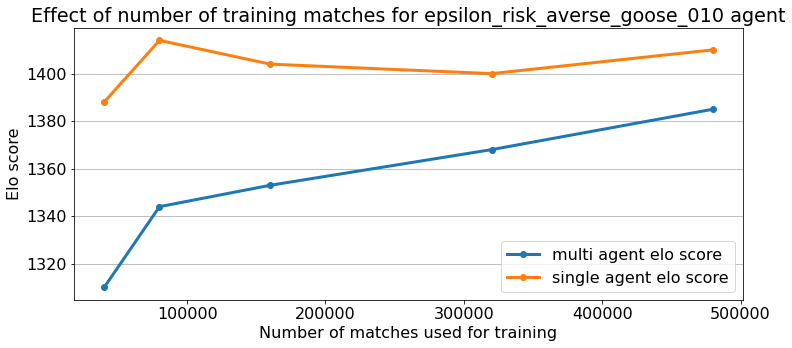

In [29]:
plt.figure(figsize=(12, 5))
n_matches = np.array([10, 20, 40, 80, 120])*4000
plt.plot(n_matches, df.multi, marker='o', label='multi agent elo score')
plt.plot(n_matches, df.single, marker='o', label='single agent elo score')
plt.legend(loc=0)
plt.grid(axis='y')
plt.xlabel('Number of matches used for training')
plt.ylabel('Elo score')
plt.title('Effect of number of training matches for epsilon_risk_averse_goose_010 agent');

For this case adding more matches improves the multi agent elo score, but not the single agent elo score.

## Study reward importance

Let's see if changing the reward we can improve the agent score. The more we look into the future the more random becomes.

I will be using 40000 matches (160000 really) for faster creation of the datasets.

### Generation

In [18]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'
for reward_name in ['ranking_reward_-4_3', 'ranking_reward_-3_2', 'ranking_reward_-1_1']:
    for n_matches in [2000, 40000]:
        saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
                os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [n_matches]]
        output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
            reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
        create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 16:53:11,868 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 62.20 GB
2021-03-25 16:53:16,085 - hungry_geese.utils - INFO - ram_memory used: 1.23 GB	 available: 61.29 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-25 16:53:52,705 - hungry_geese.utils - INFO - ram_memory used: 1.69 GB	 available: 60.89 GB
2021-03-25 16:53:52,706 - __main__ - INFO - Going to combine the data
2021-03-25 16:53:52,951 - hungry_geese.utils - INFO - ram_memory used: 1.80 GB	 available: 60.78 GB
2021-03-25 16:53:52,952 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-25 16:53:52,953 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_3/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-25 16:53:59,686 - hungry_geese.utils - INFO - ram_memory used: 1.07 GB	 available: 61.50 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 16:53:59,725 - hungry_geese.utils - INFO - ram_memory used: 1.07 GB	 available: 61.50 GB
2021-03-25 16:55:10,912 - hungry_geese.utils - INFO - ram_memory used: 18.60 GB	 available: 43.85 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-25 17:06:58,460 - hungry_geese.utils - INFO - ram_memory used: 27.08 GB	 available: 35.37 GB
2021-03-25 17:06:58,461 - __main__ - INFO - Going to combine the data
2021-03-25 17:07:08,577 - hungry_geese.utils - INFO - ram_memory used: 28.80 GB	 available: 33.65 GB
2021-03-25 17:07:08,578 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-25 17:07:08,579 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_3/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-25 17:09:09,416 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 47.87 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 17:09:09,435 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 47.87 GB
2021-03-25 17:09:13,224 - hungry_geese.utils - INFO - ram_memory used: 15.48 GB	 available: 46.96 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-25 17:09:47,892 - hungry_geese.utils - INFO - ram_memory used: 15.23 GB	 available: 47.20 GB
2021-03-25 17:09:47,893 - __main__ - INFO - Going to combine the data
2021-03-25 17:09:48,043 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 47.82 GB
2021-03-25 17:09:48,044 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-25 17:09:48,044 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-3_2/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-25 17:09:54,259 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 47.81 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 17:09:54,278 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 47.81 GB
2021-03-25 17:11:03,120 - hungry_geese.utils - INFO - ram_memory used: 32.13 GB	 available: 30.30 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-25 17:22:53,118 - hungry_geese.utils - INFO - ram_memory used: 27.09 GB	 available: 35.34 GB
2021-03-25 17:22:53,119 - __main__ - INFO - Going to combine the data
2021-03-25 17:23:03,920 - hungry_geese.utils - INFO - ram_memory used: 28.81 GB	 available: 33.64 GB
2021-03-25 17:23:03,921 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-25 17:23:03,921 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-3_2/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-25 17:25:09,897 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 47.73 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 17:25:09,920 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 47.73 GB
2021-03-25 17:25:13,765 - hungry_geese.utils - INFO - ram_memory used: 15.48 GB	 available: 46.87 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-25 17:25:49,199 - hungry_geese.utils - INFO - ram_memory used: 15.23 GB	 available: 47.15 GB
2021-03-25 17:25:49,200 - __main__ - INFO - Going to combine the data
2021-03-25 17:25:49,356 - hungry_geese.utils - INFO - ram_memory used: 14.62 GB	 available: 47.75 GB
2021-03-25 17:25:49,357 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-25 17:25:49,358 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-1_1/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-25 17:25:55,749 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 47.77 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 17:25:55,796 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 47.75 GB
2021-03-25 17:27:10,756 - hungry_geese.utils - INFO - ram_memory used: 32.13 GB	 available: 10.10 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-25 17:40:56,739 - hungry_geese.utils - INFO - ram_memory used: 27.09 GB	 available: 14.73 GB
2021-03-25 17:40:56,740 - __main__ - INFO - Going to combine the data
2021-03-25 17:41:17,833 - hungry_geese.utils - INFO - ram_memory used: 28.74 GB	 available: 13.03 GB
2021-03-25 17:41:17,840 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-25 17:41:17,841 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-1_1/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-25 17:43:32,029 - hungry_geese.utils - INFO - ram_memory used: 14.54 GB	 available: 27.14 GB


In [18]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'
for reward_name in ['ranking_reward_-10_4']:
    for n_matches in [2000]:
        saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
                os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [n_matches]]
        output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
            reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
        create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 18:29:06,922 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 41.52 GB
2021-03-25 18:29:11,521 - hungry_geese.utils - INFO - ram_memory used: 1.23 GB	 available: 40.67 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-25 18:29:49,828 - hungry_geese.utils - INFO - ram_memory used: 1.69 GB	 available: 40.15 GB
2021-03-25 18:29:49,829 - __main__ - INFO - Going to combine the data
2021-03-25 18:29:50,084 - hungry_geese.utils - INFO - ram_memory used: 1.79 GB	 available: 40.05 GB
2021-03-25 18:29:50,085 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-25 18:29:50,086 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-10_4/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-25 18:29:57,067 - hungry_geese.utils - INFO - ram_memory used: 1.07 GB	 available: 40.80 GB


In [ ]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'
for reward_name in ['ranking_reward_-10_4']:
    for n_matches in [40000]:
        saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
                os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [n_matches]]
        output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
            reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
        create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

In [32]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'
for reward_name in ['ranking_reward_-7_3', 'ranking_reward_-4_2']:
    for n_matches in [2000, 40000]:
        saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
                os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [n_matches]]
        output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
            reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
        create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 18:52:46,030 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 27.56 GB
2021-03-25 18:52:51,226 - hungry_geese.utils - INFO - ram_memory used: 15.47 GB	 available: 26.72 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-25 18:53:28,666 - hungry_geese.utils - INFO - ram_memory used: 15.22 GB	 available: 26.94 GB
2021-03-25 18:53:28,667 - __main__ - INFO - Going to combine the data
2021-03-25 18:53:28,860 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 27.55 GB
2021-03-25 18:53:28,860 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-25 18:53:28,861 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-7_3/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-25 18:53:35,746 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 27.53 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 18:53:35,787 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 27.53 GB
2021-03-25 18:55:09,180 - hungry_geese.utils - INFO - ram_memory used: 32.12 GB	 available: 10.08 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-25 19:08:32,816 - hungry_geese.utils - INFO - ram_memory used: 27.08 GB	 available: 14.90 GB
2021-03-25 19:08:32,817 - __main__ - INFO - Going to combine the data
2021-03-25 19:08:50,778 - hungry_geese.utils - INFO - ram_memory used: 28.80 GB	 available: 13.44 GB
2021-03-25 19:08:50,779 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-25 19:08:50,779 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-7_3/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-25 19:11:07,199 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 27.46 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 19:11:07,227 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 27.46 GB
2021-03-25 19:11:12,862 - hungry_geese.utils - INFO - ram_memory used: 15.46 GB	 available: 26.60 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-25 19:11:51,466 - hungry_geese.utils - INFO - ram_memory used: 15.22 GB	 available: 26.85 GB
2021-03-25 19:11:51,467 - __main__ - INFO - Going to combine the data
2021-03-25 19:11:51,659 - hungry_geese.utils - INFO - ram_memory used: 14.61 GB	 available: 27.45 GB
2021-03-25 19:11:51,660 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-25 19:11:51,661 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_2/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-25 19:11:58,659 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 27.47 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-25 19:11:58,685 - hungry_geese.utils - INFO - ram_memory used: 14.60 GB	 available: 27.47 GB
2021-03-25 19:13:33,331 - hungry_geese.utils - INFO - ram_memory used: 32.11 GB	 available: 9.93 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-25 19:27:12,902 - hungry_geese.utils - INFO - ram_memory used: 27.07 GB	 available: 14.99 GB
2021-03-25 19:27:12,903 - __main__ - INFO - Going to combine the data
2021-03-25 19:27:30,860 - hungry_geese.utils - INFO - ram_memory used: 28.79 GB	 available: 13.67 GB
2021-03-25 19:27:30,867 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-25 19:27:30,868 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_2/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-25 19:29:46,259 - hungry_geese.utils - INFO - ram_memory used: 14.59 GB	 available: 27.79 GB


In [29]:
agent_base = '../forum/agents/epsilon_risk_averse_goose_010.py'
for reward_name in ['ranking_reward_-10_5', 'ranking_reward_-10_6', 'ranking_reward_-10_7']:
    for n_matches in [2000, 40000]:
        saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
                os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [n_matches]]
        output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
            reward_name, os.path.splitext(os.path.basename(agent_base))[0], os.path.splitext(os.path.basename(agent_base))[0], n_matches)
        create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path)

looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-26 14:40:02,571 - hungry_geese.utils - INFO - ram_memory used: 0.41 GB	 available: 60.23 GB
2021-03-26 14:40:07,911 - hungry_geese.utils - INFO - ram_memory used: 1.27 GB	 available: 59.41 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-26 14:40:43,564 - hungry_geese.utils - INFO - ram_memory used: 1.71 GB	 available: 58.96 GB
2021-03-26 14:40:43,564 - __main__ - INFO - Going to combine the data
2021-03-26 14:40:43,791 - hungry_geese.utils - INFO - ram_memory used: 1.83 GB	 available: 58.84 GB
2021-03-26 14:40:43,792 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-26 14:40:43,792 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-10_5/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-26 14:40:50,447 - hungry_geese.utils - INFO - ram_memory used: 1.11 GB	 available: 59.56 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-26 14:40:50,467 - hungry_geese.utils - INFO - ram_memory used: 1.10 GB	 available: 59.56 GB
2021-03-26 14:42:01,456 - hungry_geese.utils - INFO - ram_memory used: 18.61 GB	 available: 42.00 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-26 14:53:29,474 - hungry_geese.utils - INFO - ram_memory used: 27.11 GB	 available: 33.48 GB
2021-03-26 14:53:29,474 - __main__ - INFO - Going to combine the data
2021-03-26 14:53:39,454 - hungry_geese.utils - INFO - ram_memory used: 28.83 GB	 available: 31.76 GB
2021-03-26 14:53:39,456 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-26 14:53:39,457 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-10_5/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-26 14:55:42,298 - hungry_geese.utils - INFO - ram_memory used: 14.64 GB	 available: 45.98 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-26 14:55:42,335 - hungry_geese.utils - INFO - ram_memory used: 14.64 GB	 available: 45.98 GB
2021-03-26 14:55:46,074 - hungry_geese.utils - INFO - ram_memory used: 15.49 GB	 available: 45.12 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-26 14:56:20,185 - hungry_geese.utils - INFO - ram_memory used: 15.25 GB	 available: 45.37 GB
2021-03-26 14:56:20,186 - __main__ - INFO - Going to combine the data
2021-03-26 14:56:20,340 - hungry_geese.utils - INFO - ram_memory used: 14.64 GB	 available: 45.98 GB
2021-03-26 14:56:20,341 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-26 14:56:20,342 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-10_6/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-26 14:56:26,687 - hungry_geese.utils - INFO - ram_memory used: 14.64 GB	 available: 45.97 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-26 14:56:26,707 - hungry_geese.utils - INFO - ram_memory used: 14.64 GB	 available: 45.97 GB
2021-03-26 14:57:35,961 - hungry_geese.utils - INFO - ram_memory used: 32.14 GB	 available: 28.44 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-26 15:09:03,982 - hungry_geese.utils - INFO - ram_memory used: 27.10 GB	 available: 33.45 GB
2021-03-26 15:09:03,983 - __main__ - INFO - Going to combine the data
2021-03-26 15:09:14,316 - hungry_geese.utils - INFO - ram_memory used: 28.84 GB	 available: 31.71 GB
2021-03-26 15:09:14,317 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-26 15:09:14,318 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-10_6/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-26 15:11:17,451 - hungry_geese.utils - INFO - ram_memory used: 14.64 GB	 available: 45.92 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-26 15:11:17,472 - hungry_geese.utils - INFO - ram_memory used: 14.64 GB	 available: 45.92 GB
2021-03-26 15:11:21,360 - hungry_geese.utils - INFO - ram_memory used: 15.49 GB	 available: 45.07 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-26 15:11:55,327 - hungry_geese.utils - INFO - ram_memory used: 15.24 GB	 available: 45.34 GB
2021-03-26 15:11:55,328 - __main__ - INFO - Going to combine the data
2021-03-26 15:11:55,486 - hungry_geese.utils - INFO - ram_memory used: 14.65 GB	 available: 45.93 GB
2021-03-26 15:11:55,487 - __main__ - INFO - Size of the boards is 0.7 GB ([0.7, 0.0, 0.0, 0.0] [0.7 GB])
2021-03-26 15:11:55,488 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-10_7/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz
2021-03-26 15:12:01,903 - hungry_geese.utils - INFO - ram_memory used: 14.65 GB	 available: 45.92 GB


looping over saved games:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-26 15:12:01,923 - hungry_geese.utils - INFO - ram_memory used: 14.65 GB	 available: 45.92 GB
2021-03-26 15:13:12,062 - hungry_geese.utils - INFO - ram_memory used: 32.14 GB	 available: 28.40 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-26 15:24:41,016 - hungry_geese.utils - INFO - ram_memory used: 27.10 GB	 available: 33.40 GB
2021-03-26 15:24:41,017 - __main__ - INFO - Going to combine the data
2021-03-26 15:24:51,270 - hungry_geese.utils - INFO - ram_memory used: 28.85 GB	 available: 31.66 GB
2021-03-26 15:24:51,271 - __main__ - INFO - Size of the boards is 13.6 GB ([13.6, 0.4, 0.2, 0.0] [14.2 GB])
2021-03-26 15:24:51,272 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-10_7/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_40000.npz
2021-03-26 15:26:54,105 - hungry_geese.utils - INFO - ram_memory used: 14.65 GB	 available: 45.89 GB


### Study reward distribution

Let's compare the reward distribution from matches vs epsilon player against matches against greedy players.

#### Plots

In [18]:
def plot_reward_distribution(filepath):
    rewards = np.load(filepath)['rewards']
    plt.hist(rewards, bins=100, log=False)
    plt.grid(axis='y')
    plt.title('Reward distribution for %s' % filepath)

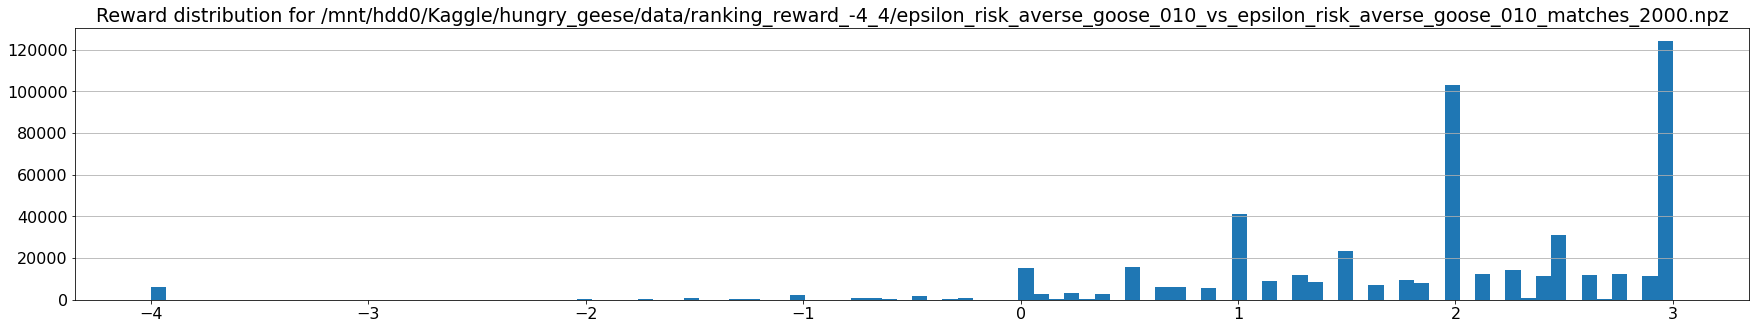

In [30]:
plot_reward_distribution('/mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz')

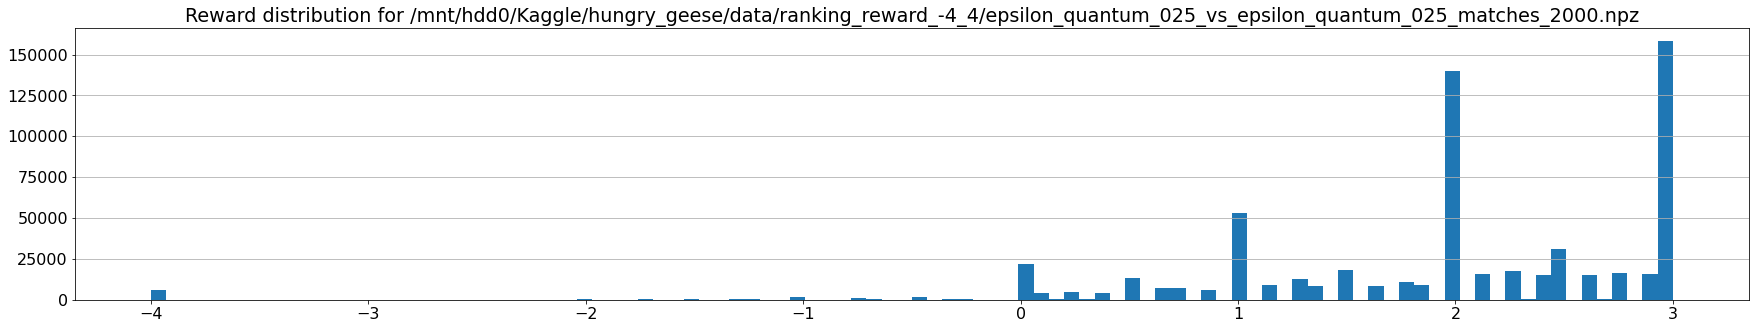

In [32]:
plot_reward_distribution('/mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_025_vs_epsilon_quantum_025_matches_2000.npz')

Those are distributions for playing with and against epsilon players. We can see that negative rewards are scarce, because they only happen when the agent dies.

Below we can see the distribution for a player that uses epsilon greedy policy against greedy players. In this case reward 3 is the most common, so this indicates
that the agent is leading frequently the games.

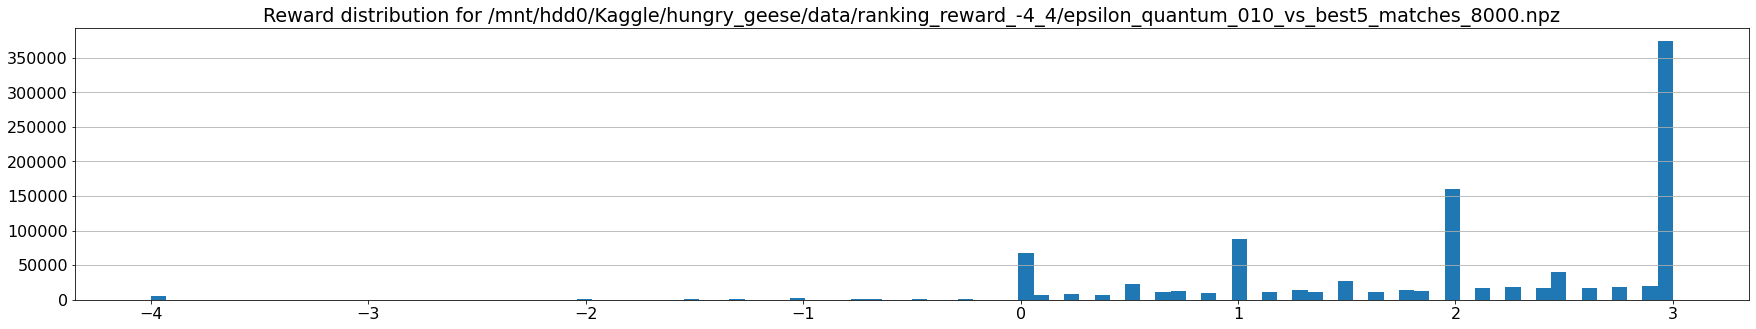

In [31]:
plot_reward_distribution('/mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_matches_8000.npz')

Let's focus on the close to death rewards, to see if they diferentiate enough from typical gameplay.

In [19]:
def plot_reward_distribution_near_death(filepath, death_score=-4, backwards_steps=4):
    rewards = np.load(filepath)['rewards']
    death_indexes = np.arange(len(rewards))[rewards == death_score]
    mask = np.zeros_like(rewards)
    for offset in range(backwards_steps):
        mask[death_indexes - offset] = 1
    bins = np.linspace(death_score, 3, 100)
    plt.hist(rewards[mask==1], bins=bins, log=False, density=True, label='distributions_near_death')
    plt.hist(rewards[mask==0], bins=bins, log=False, density=True, alpha=0.5, label='distributions_near_death')
    plt.grid(axis='y')
    plt.title('Reward distribution for %s' % filepath)

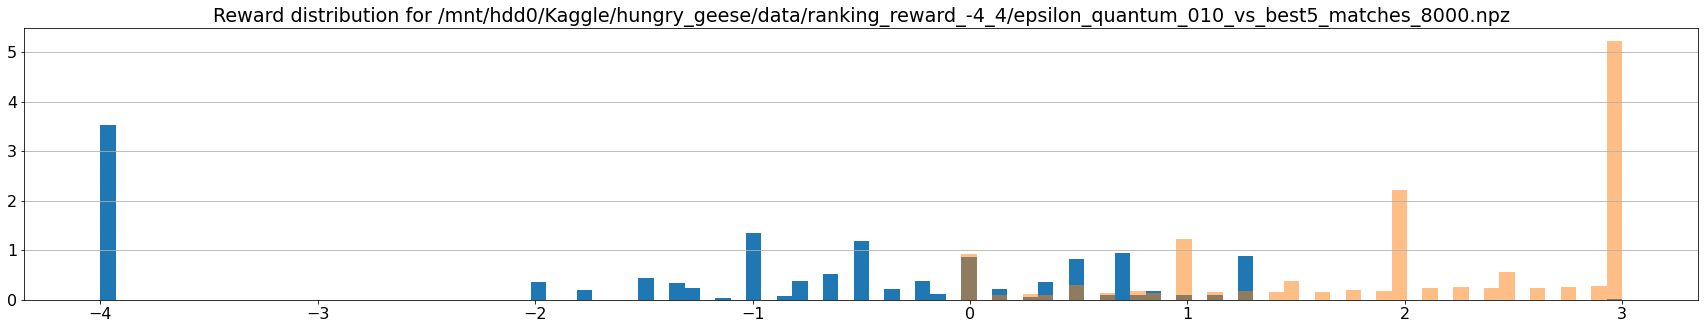

In [26]:
plot_reward_distribution_near_death('/mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_matches_8000.npz')

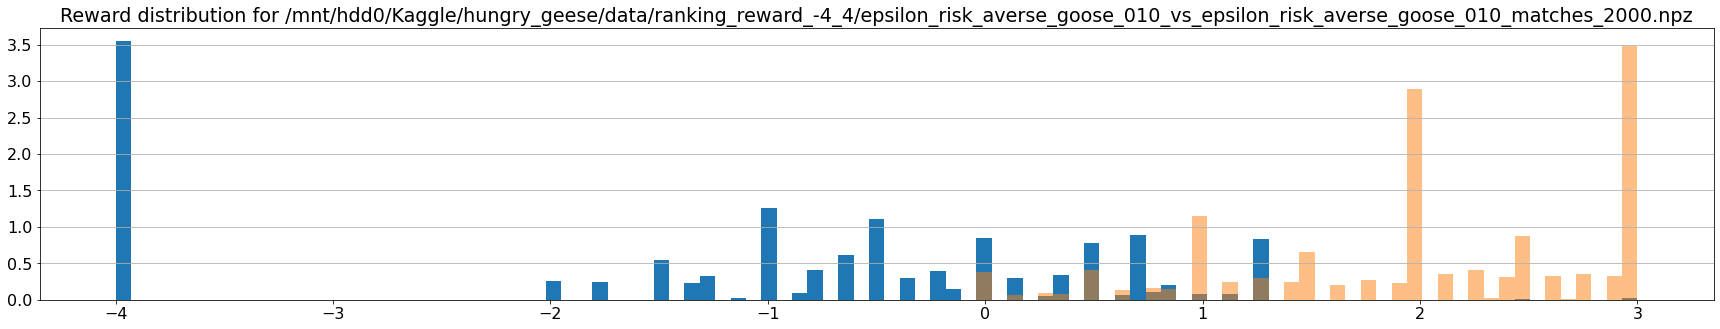

In [27]:
plot_reward_distribution_near_death('/mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz')

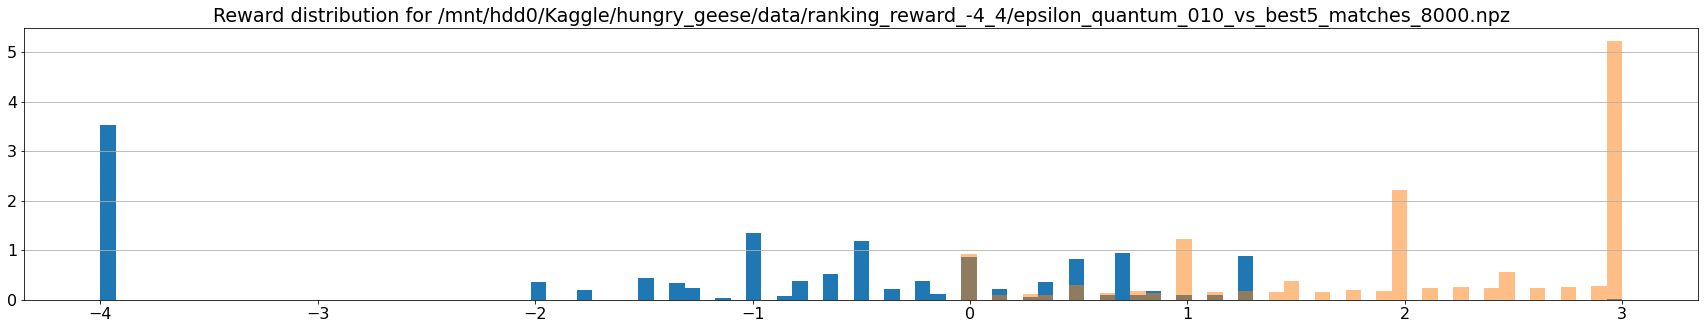

In [30]:
plot_reward_distribution_near_death('/mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_quantum_010_vs_best5_matches_8000.npz')

We can see that there is overlap between normal play distribution and near death distribution. We could solve this problem by decreasing the death score.

Below we can see an alternative reward that completely splits near death and typical game situations.

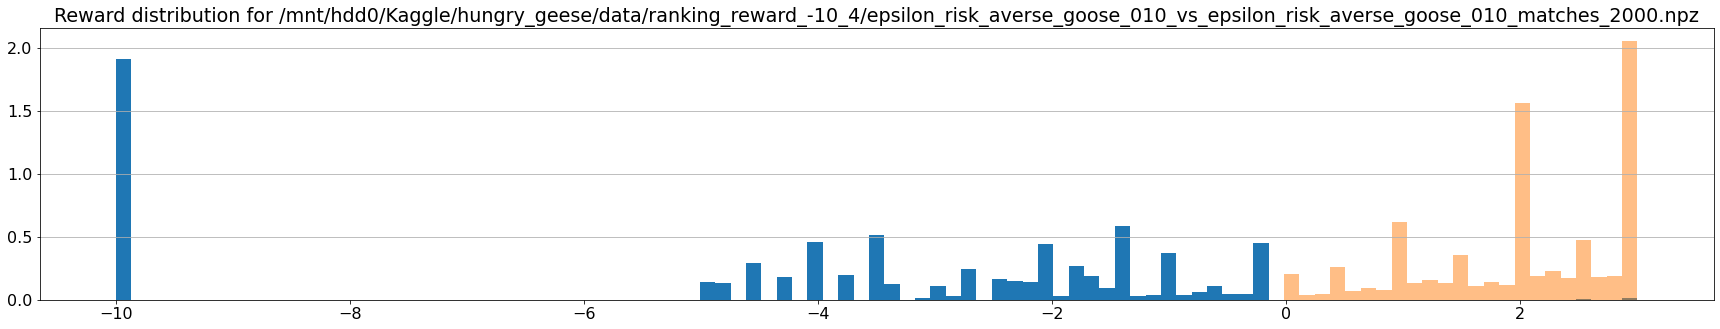

In [28]:
plot_reward_distribution_near_death('/mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-10_4/epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_matches_2000.npz', death_score=-10)

I'm going to train with this kind of distribution to see if it brings better results. Reward should be -(window_size-1)*3-1

#### Summary

- The reward distribution does not show big differences between games against greedy or epsilon greedy agents.
- A new reward is proposed that may improve the death prediction of the agent, we should visualize once the models are trained

### Evaluation

In [20]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/27_reward_study/*/q_value_agent.py'))[:-1]
print(agent_filepaths)
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    name = os.path.basename(os.path.dirname(agent_filepath))
    name = '_'.join(name.split('_')[-5:-2])
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
df

/mnt/hdd0/Kaggle/hungry_geese/models/27_reward_study/06_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-7_3_x128_40000/q_value_agent.py
Multi agent elo score: 1339
Single agent elo score: 1356


,multi,single
reward_-4_4,1368.0,1375.0
reward_-4_3,1298.0,1399.0
reward_-3_2,1291.0,1319.0
reward_-1_1,1058.0,1053.0
reward_-10_4,1362.0,1384.0
reward_-7_3,1339.0,1356.0


In [21]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/27_reward_study/*/q_value_agent.py'))[-1:]
print(agent_filepaths)
for agent_filepath in agent_filepaths:
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    name = os.path.basename(os.path.dirname(agent_filepath))
    name = '_'.join(name.split('_')[-5:-2])
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
df

/mnt/hdd0/Kaggle/hungry_geese/models/27_reward_study/07_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-4_2_x128_40000/q_value_agent.py
Multi agent elo score: 1300
Single agent elo score: 1295


,multi,single
reward_-4_4,1368.0,1375.0
reward_-4_3,1298.0,1399.0
reward_-3_2,1291.0,1319.0
reward_-1_1,1058.0,1053.0
reward_-10_4,1362.0,1384.0
reward_-7_3,1339.0,1356.0
reward_-4_2,1300.0,1295.0


It seems that the negative reward does not matter.

In [21]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/27_reward_study/*/q_value_agent.py'))[-3:]
print(agent_filepaths)
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    name = os.path.basename(os.path.dirname(agent_filepath))
    name = '_'.join(name.split('_')[-5:-2])
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
df

/mnt/hdd0/Kaggle/hungry_geese/models/27_reward_study/10_epsilon_risk_averse_goose_010_vs_epsilon_risk_averse_goose_010_reward_-10_7_x128_40000/q_value_agent.py
Multi agent elo score: 1363
Single agent elo score: 1382


,multi,single
reward_-10_5,1376.0,1363.0
reward_-10_6,1385.0,1386.0
reward_-10_7,1363.0,1382.0


There is no significative improvement.

## Architecture study

In [20]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/*/q_value_agent.py'))
print(agent_filepaths)
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    name = os.path.basename(os.path.dirname(agent_filepath))
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
df

/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/08_smaller_encoder_tanh3/q_value_agent.py
Multi agent elo score: 1325
Single agent elo score: 1368


,multi,single
01_baseline_x128,1360.0,1391.0
02_tanh2,1387.0,1391.0
03_all_relu,1344.0,1388.0
04_remove_one_convolution,1360.0,1381.0
05_smaller_mlp,1330.0,1368.0
06_smaller_encoder,1352.0,1401.0
07_smaller_encoder_tanh2,1347.0,1417.0
08_smaller_encoder_tanh3,1325.0,1368.0


Let's study repeteability of the evaluation.

In [20]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/*/q_value_agent.py'))
print(agent_filepaths)
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    for idx in range(5):
        print(df)
        ret = simple_agent_evaluation(agent_filepath, n_matches=500)
        name = os.path.basename(os.path.dirname(agent_filepath))
        df.loc[name, 'multi %i' % idx] = ret[0]
        df.loc[name, 'single %i' % idx] = ret[1]
df

/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/08_smaller_encoder_tanh3/q_value_agent.py
Multi agent elo score: 1325
Single agent elo score: 1365


,multi 0,single 0,multi 1,single 1,multi 2,single 2,multi 3,single 3,multi 4,single 4
01_baseline_x128,1349.0,1366.0,1356.0,1404.0,1377.0,1420.0,1352.0,1405.0,1360.0,1405.0
02_tanh2,1359.0,1396.0,1369.0,1400.0,1364.0,1381.0,1363.0,1386.0,1346.0,1394.0
03_all_relu,1350.0,1346.0,1363.0,1386.0,1347.0,1397.0,1361.0,1398.0,1355.0,1374.0
04_remove_one_convolution,1390.0,1362.0,1344.0,1406.0,1381.0,1378.0,1350.0,1395.0,1368.0,1398.0
05_smaller_mlp,1316.0,1362.0,1321.0,1373.0,1380.0,1358.0,1332.0,1382.0,1354.0,1353.0
06_smaller_encoder,1346.0,1398.0,1364.0,1376.0,1342.0,1388.0,1371.0,1383.0,1345.0,1378.0
07_smaller_encoder_tanh2,1373.0,1428.0,1384.0,1434.0,1363.0,1400.0,1367.0,1400.0,1353.0,1405.0
08_smaller_encoder_tanh3,1355.0,1346.0,1340.0,1379.0,1360.0,1407.0,1330.0,1383.0,1325.0,1365.0


In [25]:
np.mean(np.std(df.values[:, ::2], axis=1)), np.mean(np.std(df.values[:, 1::2], axis=1))

(12.569588774727587, 14.141928898091304)

In [27]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/*/q_value_agent.py'))
print(agent_filepaths)
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    for idx in range(5):
        print(df)
        ret = simple_agent_evaluation(agent_filepath, n_matches=100)
        name = os.path.basename(os.path.dirname(agent_filepath))
        df.loc[name, 'multi %i' % idx] = ret[0]
        df.loc[name, 'single %i' % idx] = ret[1]
print(np.mean(np.std(df.values[:, ::2], axis=1)), np.mean(np.std(df.values[:, 1::2], axis=1)))
df

/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/08_smaller_encoder_tanh3/q_value_agent.py
Multi agent elo score: 1359
Single agent elo score: 1319
28.340839951974864 26.982621734399565


,multi 0,single 0,multi 1,single 1,multi 2,single 2,multi 3,single 3,multi 4,single 4
01_baseline_x128,1395.0,1358.0,1353.0,1389.0,1333.0,1378.0,1336.0,1419.0,1341.0,1437.0
02_tanh2,1361.0,1429.0,1402.0,1452.0,1333.0,1430.0,1394.0,1355.0,1336.0,1353.0
03_all_relu,1313.0,1385.0,1296.0,1340.0,1390.0,1360.0,1359.0,1389.0,1376.0,1383.0
04_remove_one_convolution,1355.0,1389.0,1364.0,1411.0,1335.0,1334.0,1413.0,1358.0,1336.0,1315.0
05_smaller_mlp,1283.0,1378.0,1325.0,1389.0,1361.0,1360.0,1302.0,1412.0,1308.0,1393.0
06_smaller_encoder,1357.0,1373.0,1304.0,1374.0,1367.0,1341.0,1324.0,1338.0,1371.0,1337.0
07_smaller_encoder_tanh2,1379.0,1412.0,1375.0,1346.0,1363.0,1406.0,1336.0,1420.0,1375.0,1372.0
08_smaller_encoder_tanh3,1347.0,1320.0,1323.0,1350.0,1278.0,1379.0,1407.0,1393.0,1359.0,1319.0


In [28]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/*/q_value_agent.py'))
print(agent_filepaths)
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    for idx in range(5):
        print(df)
        ret = simple_agent_evaluation(agent_filepath, n_matches=1000)
        name = os.path.basename(os.path.dirname(agent_filepath))
        df.loc[name, 'multi %i' % idx] = ret[0]
        df.loc[name, 'single %i' % idx] = ret[1]
print(np.mean(np.std(df.values[:, ::2], axis=1)), np.mean(np.std(df.values[:, 1::2], axis=1)))
df

/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/08_smaller_encoder_tanh3/q_value_agent.py
Multi agent elo score: 1372
Single agent elo score: 1366
12.288209215181263 11.805020567776232


,multi 0,single 0,multi 1,single 1,multi 2,single 2,multi 3,single 3,multi 4,single 4
01_baseline_x128,1344.0,1408.0,1365.0,1408.0,1369.0,1407.0,1360.0,1404.0,1366.0,1368.0
02_tanh2,1365.0,1414.0,1342.0,1403.0,1330.0,1387.0,1364.0,1405.0,1330.0,1382.0
03_all_relu,1351.0,1356.0,1343.0,1355.0,1365.0,1384.0,1332.0,1360.0,1364.0,1389.0
04_remove_one_convolution,1325.0,1376.0,1351.0,1375.0,1362.0,1394.0,1353.0,1380.0,1353.0,1383.0
05_smaller_mlp,1303.0,1389.0,1336.0,1403.0,1329.0,1385.0,1328.0,1373.0,1355.0,1422.0
06_smaller_encoder,1345.0,1378.0,1360.0,1369.0,1369.0,1385.0,1356.0,1378.0,1343.0,1378.0
07_smaller_encoder_tanh2,1382.0,1389.0,1360.0,1392.0,1355.0,1398.0,1376.0,1398.0,1369.0,1408.0
08_smaller_encoder_tanh3,1365.0,1363.0,1335.0,1336.0,1356.0,1385.0,1354.0,1380.0,1372.0,1366.0


Ok, so this means that we need differences of around 50 (12*2*1.96) in elo score to be 95% confidence of a real difference if we use 500 matches. Differences of 35 will have a 80% of probability of being true.

In [47]:
df

,multi,single
01_baseline_x128,1352.0,1389.0
02_tanh2,1330.0,1413.0
03_all_relu,1353.0,1398.0
04_remove_one_convolution,1365.0,1393.0
05_smaller_mlp,1340.0,1373.0
06_smaller_encoder,1353.0,1440.0
07_smaller_encoder_tanh2,1372.0,1396.0
08_smaller_encoder_tanh3,1374.0,1366.0


In [21]:
simple_agent_evaluation('../forum/agents/epsilon_risk_averse_goose_002.py', n_matches=500)

../forum/agents/epsilon_risk_averse_goose_002.py
Multi agent elo score: 1088
Single agent elo score: 1156


(1088, 1156)

In [22]:
simple_agent_evaluation('../forum/agents/epsilon_risk_averse_goose_005.py', n_matches=500)

../forum/agents/epsilon_risk_averse_goose_005.py
Multi agent elo score: 925
Single agent elo score: 949


(925, 949)

## Useful snippets

In [ ]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:4]]
best_5_agents += ['/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/04_epsilon010_vs_best5_reward_-4_4_x128_80000_pretrained/q_value_agent.py']
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()

for n_matches in [8000, 39000, 40000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)
    
reward_name = 'ranking_reward_-4_4'

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [8000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 8000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [39000, 40000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 80000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

In [ ]:
agent_names = initial_elo_ranking.index.values.tolist()[:4]
output_folder = '../data/saved_games/02_quantum'
save_html_games([agents[name] for name in agent_names], output_folder, n_games=10)

In [ ]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/01_epsilon025_reward_-4_4_x128_30000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

## Summary